In [195]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.cm as cm
import math
import mat73
from datetime import datetime
import calendar
import allantools as al
import re
from scipy.stats import poisson
from scipy.stats import norm
import gmpy2 as gm
import mpmath as mp
from scipy.optimize import root_scalar as root
from scipy.stats import chisquare
import csv

In [42]:
tInt = 1e-3*((20+2+0.1+20+1+50+1+2+3+2+0.2+0.2+15+3)*3*4 + (20+2+0.1+20+14+16+8+14+3+3+5+0.4+20)*4 + (20+2+0.1+20+26.2+150+32.5+3+3+5+0.4+20)*4)
print(tInt)

3.0648000000000004


In [43]:
mp.mp.dps = 50
fe3 = mp.mpf('642121496772645.10')
fe2 = mp.mpf('688358979309308.22')
R_Godun = mp.mpf('0.93282940453096496') #mp.mpf('0.93282940453096465')
R_Lange = mp.mpf('0.932829404530965376')

In [44]:
B = mp.mpf(31.275/(1e-9*0.59930*9.2740100657e-24/6.626e-34)) # in mu T
e2Zee = 52.14*B**2*1e-3
e3Zee = -2.082*B**2*1e-3
e2BBR = -480e-18*fe2 #-537e-18*fe2 #-517e-18*fe2
##Changed 9/15/25 to account for second order doppler and dc stark in quadrupole
e3BBR = -68e-18*fe3 #-73.6e-18*fe3
##Changed to 68 on 9/23/15 for 23 degree lab
e2Quad = 0.0 #0.049409
e3Quad = 0.0 #-0.049409/92.1
e2Shift = (e2Zee+e2BBR+e2Quad)
e3Shift = (e3Zee+e3BBR+e3Quad)

In [45]:
def psi(g,e):
    return np.array([g, e])
    
def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

In [46]:
def rhoQuad(delta, Omega0, rho22, t, T):
    psi0 = psi(1.0, 0.0)
    return 0.62*rhoee(pulse(t, Omega0, delta, 0.0, 0.0)@pulse(T, 0.0, delta, 0.0, 0.0)@pulse(t, Omega0, delta, 0.0, 0.0)@psi0)-rho22
def rho2deltaRamseyQuad(Omega0, rho22, t, T):
    return root(rhoQuad, args=(Omega0,rho22, t, T), bracket=[0.0,2*np.pi/(T*2)]).root
def rhoRamsey(delta, Omega0, rho22, t, T):
    psi0 = psi(1.0, 0.0)
    return rhoee(pulse(t, Omega0, delta, 0.0, 0.0)@pulse(T, 0.0, delta, 0.0, 0.0)@pulse(t, Omega0, delta, 0.0, 0.0)@psi0)-rho22
def rho2deltaRamsey(Omega0, rho22, t, T):
    return root(rhoRamsey, args=(Omega0,rho22, t, T), bracket=[0.0,Omega0/4]).root

In [47]:
def importExcFracs(filename, ni, nf):
    mat = mat73.loadmat(filename)
    taoms=mat['aomfrequsmatrix'][ni:nf,0]
    for ii in range(np.size(taoms)):
        taoms[ii] = nowToEpoch(taoms[ii])         #times now in epoch time
    fe2aom1=mat['aomfrequsmatrix'][ni:nf,1]
    fe2aom2=mat['aomfrequsmatrix'][ni:nf,2]
    fe2aom3=mat['aomfrequsmatrix'][ni:nf,3]
    fe2aoms = [fe2aom1,fe2aom2,fe2aom3]
    fe3aom=mat['aomfrequsmatrix'][ni:nf,4]
    rRquad1=mat['aomfrequsmatrix'][ni+1:nf,6]
    rRquad2=mat['aomfrequsmatrix'][ni+1:nf,7]
    rRquad3=mat['aomfrequsmatrix'][ni+1:nf,8]
    rRquads = [rRquad1,rRquad2,rRquad3]
    rRoct = mat['aomfrequsmatrix'][ni+1:nf,10]
    return taoms, fe2aoms, fe3aom, rRquads, rRoct

In [48]:
def calcLeftExcsQuad(rRquads, fe2aoms, tRabi):
    #deltafrequQuad = 1/2*15*28/(tRabi*1e3)
    deltafrequQuad = 1/2*15*28/(40)
    g = deltafrequQuad/30
    rLquads = [np.zeros(np.size(rRquads[0])),np.zeros(np.size(rRquads[0])),np.zeros(np.size(rRquads[0]))]
    for jj in range(3):
        for ii in range(np.size(rRquads[0])):
            rLquads[jj][ii] = rRquads[jj][ii]-0.5*(fe2aoms[jj][ii+1]-fe2aoms[jj][ii])/g
    if np.min(rLquads)<(-0.1) or np.max(rLquads)>1.1: print("Warning!!! Excitation fraction calc error")
    for jj in range(3):
        rLquads[jj] = np.round(rLquads[jj]*2)/2
    return rLquads

def calcLeftExcsOct(rRoct, fe3aom):
    tekDeltafrequ = 13*3/4
    g = tekDeltafrequ/(3*30*2)
    rLoct = np.zeros(np.size(rRoct))
    for ii in range(np.size(rRoct)):
        rLoct[ii] = rRoct[ii]+0.5*(fe3aom[ii+1]-fe3aom[ii])/g
    
    if np.min(rLoct)<(-0.1) or np.max(rLoct)>1.1: print("Warning!!! Excitation fraction calc error")
    rLoct = np.round(rLoct*2)/2
    return rLoct

In [49]:
def servoError(aomFile, matni, matnf, tquad, TQuad, toct, TOct):
    taoms, fe2aoms, fe3aom, rRquads, rRoct = importExcFracs(aomFile, matni, matnf)
    #taoms = taoms[matni:matnf]
    #fe3aom = fe3aom[matni:matnf]
    #rRoct = rRoct[matni:matnf]
    #for ii in range(3):
    #    fe2aoms[ii] = fe2aoms[ii][matni:matnf]
    #    rRquads[ii] = rRquads[ii][matni:matnf]
    rLquads = calcLeftExcsQuad(rRquads, fe2aoms, TQuad)
    rLoct = calcLeftExcsOct(rRoct, fe3aom)
    print("oct exc fracs: ")
    print(np.average(rRoct), np.average(rLoct))
    octServoErr = (rho2deltaRamsey(np.pi/(2*toct), np.average(rRoct), toct, TOct)- rho2deltaRamsey(np.pi/(2*toct), np.average(rLoct), toct, TOct))/(2.0*np.pi)
    quadServoErrs = np.zeros(3)
    print(np.average(rRquads[1]), np.average(rLquads[1]))
    for ii in range(3):
        quadServoErrs[ii] = (rho2deltaRamseyQuad(np.pi/(2*tquad), np.average(rLquads[ii]), tquad, TQuad) - rho2deltaRamseyQuad(np.pi/(2*tquad), np.average(rRquads[ii]), tquad, TQuad))/(2.0*np.pi)
    return octServoErr, quadServoErrs

In [50]:
def snipData(data, Ncutf):
    ts, f933s, f871s, taoms, fe2aoms, fe3aom, matni, matnf, beatSign933, beatSign871, frep = data
    taoms = taoms[:Ncutf]
    for ii in range(3):
        fe2aoms[ii] = fe2aoms[ii][:Ncutf]
    fe3aom = fe3aom[:Ncutf]
    ts, f933s, f871s, taoms, fe2aoms, fe3aom, matni, matnf = trimData(ts, f933s, f871s, taoms, fe2aoms, fe3aom)
    return [ts, f933s, f871s, taoms, fe2aoms, fe3aom, matni, matnf, beatSign933, beatSign871, frep]

In [51]:
def lineFit(x,m,b):
    return m*x+b
def Gauss(x, A, sig, mu): 
    y = (A/np.sqrt(2*np.pi*sig**2))*np.exp((-(x-mu)**2)/(2.*sig**2)) 
    return y 

def linePts(x, y):
    n = np.size(x)
    fitYs = np.zeros(n)
    param, paramcov = curve_fit(lineFit,x,y, maxfev=5000)
    print(param[0])
    for ii in range(n):
        fitYs[ii] = lineFit(x[ii], param[0], param[1])
    return fitYs

def arbTimetoEpoch(t,t0): #takes t, time elapsed in s since t0 (a date time) and returns epoch time corresponding to t
    return t + t0.timestamp()

def nowToEpoch(time): #takes matlab "now" serial date number in days from Jan 1 0000 and converts to epoch time (s from 1970)
    dec = math.modf(time)[0]
    ing = int(math.modf(time)[1])
    t = datetime.fromordinal(ing-366).timestamp() + dec*24*60*60
    return t

In [52]:
def importMokuPro(filename):
    lines=[]
    with open(filename, 'r') as file:
        for line in file:
            lines.append(line)
            #print(line.strip()) 
    lines = lines[14:]
    n = len(lines)
    ts = np.zeros(n)
    f729 = np.zeros(n)
    f871 = np.zeros(n)
    f933 = np.zeros(n)
    for ii in range(n):
        entries = lines[ii].split(',')
        ts[ii] = float(entries[0])
        #f729[ii] = float(entries[2])
        f871[ii] = float(entries[2]) #float(entries[7])-70e6 
        f933[ii] = float(entries[7]) #float(entries[12]) 

    match = re.search(r"(\d{4})(\d{2})(\d{2})_(\d{2})(\d{2})(\d{2})", filename)
    dt = tuple(map(int, match.groups()))
    #print(dt)
    ts = arbTimetoEpoch(ts, datetime(*dt))
    return ts, f871, f933

def importMokuProwCEOmix(filename):
    lines=[]
    with open(filename, 'r') as file:
        for line in file:
            lines.append(line)
            #print(line.strip()) 
    lines = lines[14:]
    n = len(lines)
    ts = np.zeros(n)
    f871 = np.zeros(n)
    f933 = np.zeros(n)
    for ii in range(n):
        entries = lines[ii].split(',')
        ts[ii] = float(entries[0])
        #f729[ii] = float(entries[2])
        f871[ii] = float(entries[2])-mp.mpf('70e6') 
        f933[ii] = float(entries[7]) 

    match = re.search(r"(\d{4})(\d{2})(\d{2})_(\d{2})(\d{2})(\d{2})", filename)
    dt = tuple(map(int, match.groups()))
    #print(dt)
    ts = arbTimetoEpoch(ts, datetime(*dt))
    return ts, f871, f933

def importMokuProwCEOmixw729(filename):
    lines=[]
    with open(filename, 'r') as file:
        for line in file:
            lines.append(line)
            #print(line.strip()) 
    lines = lines[14:]
    n = len(lines)
    ts = np.zeros(n)
    f729 = np.zeros(n)
    f871 = np.zeros(n)
    f933 = np.zeros(n)
    for ii in range(n):
        entries = lines[ii].split(',')
        ts[ii] = float(entries[0])
        f729[ii] = float(entries[2])
        f871[ii] = float(entries[7])-mp.mpf('70e6') 
        f933[ii] = float(entries[12]) 

    match = re.search(r"(\d{4})(\d{2})(\d{2})_(\d{2})(\d{2})(\d{2})", filename)
    dt = tuple(map(int, match.groups()))
    #print(dt)
    ts = arbTimetoEpoch(ts, datetime(*dt))
    return ts, f871, f933

In [53]:
def importMatlab(filename):
    mat = mat73.loadmat(filename)
    n=int(mat['currentdatapointnr'])
    ni = 250 #-----------cut off points while servo grabs---------------
    taoms=mat['aomfrequsmatrix'][ni:n-1,0]
    #print(ts[0])

    for ii in range(np.size(taoms)):
        taoms[ii] = nowToEpoch(taoms[ii])         #times now in epoch time
    fe2aom1=mat['aomfrequsmatrix'][ni:n-1,1]
    fe2aom2=mat['aomfrequsmatrix'][ni:n-1,2]
    fe2aom3=mat['aomfrequsmatrix'][ni:n-1,3]
    fe2aoms = [fe2aom1,fe2aom2,fe2aom3]
    fe3aom=mat['aomfrequsmatrix'][ni:n-1,4]
    return taoms, fe2aoms, fe3aom

In [54]:
def trimData(ts, f933s, f871s, taoms, fe2aoms, fe3aom):
    ni=0
    if ts[0]>taoms[0]:
        print("case 1")
        for ii in range(np.size(taoms)):
            if (taoms[ii] - tInt)>ts[0]: 
                ni=ii
                #print(ni)
                break
        #print(ni)
        taoms = taoms[ni:]
        for ii in range(3):
            fe2aoms[ii] = fe2aoms[ii][ni:]
        fe3aom = fe3aom[ni:]
        #print("should be negative: ")
        print(ts[0]-taoms[0])
        matni=ni
    else:
        print("case 2")
        # Cutting off first 30 points of aom data to give servo time to catch
        #--------------------------------------------------------
        #nServo = 0
        #taoms = taoms[nServo:]
        #for ii in range(3):
        #    fe2aoms[ii] = fe2aoms[ii][nServo:]
        #fe3aom = fe3aom[nServo:]
        for ii in range(np.size(ts)):
            if ts[ii]>(taoms[0]-tInt):
                ni=ii
                #print(ni)
                break
        ts = ts[ni:]
        f871s = f871s[ni:]
        f933s = f933s[ni:]
        #print("should be negative: ")
        print(ts[0]-taoms[0])
        matni=0
    if ts[-1]>taoms[-1]:
        print("case 1")
        for ii in range(np.size(ts)):
            if ts[ii]>taoms[-1]:
                nf=ii
                break
        ts = ts[:nf+1]
        f871s = f871s[:nf+1]
        f933s = f933s[:nf+1]
        #print("should be positve: ")
        print(ts[-1]-taoms[-1])
        matnf = np.size(taoms)+matni
    else:
        print("case 2")
        for ii in range(np.size(taoms)):
            if taoms[ii]>ts[-1]:
                nf=ii
                break
        #print(nf)
        taoms = taoms[:nf]
        for ii in range(3):
            fe2aoms[ii] = fe2aoms[ii][:nf]
        fe3aom = fe3aom[:nf]
        #print("should be positve: ")
        print(ts[-1]-taoms[-1])
        matnf = nf+matni
    print("matni: ", matni)
    print("matnf: ", matnf)
    return ts, f933s, f871s, taoms, fe2aoms, fe3aom, matni, matnf

In [55]:
def ratioCalc(data):
    ts, f933s, f871s, taoms, fe2aoms, fe3aom, matni, matnf, beatSign933, beatSign871, frep = data
    #Average beat note data
    n = np.size(taoms)
    f871adj = np.zeros(n)
    f933adj = np.zeros(n)
    ii = 0
    n1 = 0 
    n2 = 0
    while ii<n:
        while ts[n1] < (taoms[ii]-tInt):
            n1+=1
        while ts[n2] < taoms[ii]:
            n2 +=1
        f871adj[ii] = np.average(f871s[n1:n2])
        f933adj[ii] = np.average(f933s[n1:n2])
        ii+=1
        
    for ii in range(np.size(f871adj)):
        if f871adj[ii]==None:
            print(ii)
    #Calculate comb teeth
    fceo = mp.mpf('70e6')
    print("------Comb Teeth------")
    print((fe2/2-fceo + beatSign871*np.average(f871s)+80.0e6+(80e6+np.average(fe2aoms))/2)/frep)
    n871 = round((fe2/2-fceo + beatSign871*np.average(f871s)+80.0e6+(80e6+np.average(fe2aoms))/2)/frep)
    n871 = mp.mpf(n871)
    print(n871)
    print((fe3/2-fceo + beatSign933*np.average(f933s)+80.0e6+np.average(fe3aom)/2)/frep)
    n933 = round((fe3/2-fceo + beatSign933*np.average(f933s)+80.0e6+np.average(fe3aom)/2)/frep)
    n933 = mp.mpf(n933)
    print(n933)
    print("----------------------")

    #Calculate ratio
    nuA = fceo - beatSign871*f871adj
    nuB = (n871/n933)*(fceo-beatSign933*f933adj)
    nuC = nuA - nuB
    f933 = fe3/2 + np.average(fe3aom)/2 + 80e6
    ratio = nuC/f933+n871/n933
    e3Quad = -np.array([(fe2aoms[0][i] + fe2aoms[1][i] + fe2aoms[2][i]) / 3 for i in range(len(fe2aoms[0]))] - fe2aoms[0])/92.1
    R1 = (2-160e6/f933-fe3aom/f933-(e3Shift+e3Quad)/f933)/(2.*ratio-240e6/f933-fe2aoms[0]/f933-e2Shift/f933)
    R2 = (2-160e6/f933-fe3aom/f933-(e3Shift+e3Quad)/f933)/(2.*ratio-240e6/f933-fe2aoms[1]/f933-e2Shift/f933)
    R3 = (2-160e6/f933-fe3aom/f933-(e3Shift+e3Quad)/f933)/(2.*ratio-240e6/f933-fe2aoms[2]/f933-e2Shift/f933)
    Rs = np.array([R1,R2,R3])
    return taoms, Rs, ratio, fe3aom, fe2aoms

In [256]:
def ratioCalcwServoErr(data):
    ts, f933s, f871s, taoms, fe2aoms, fe3aom, matni, matnf, beatSign933, beatSign871, frep, aomFile, tquad, TQuad, toct, TOct = data
    #Average beat note data
    n = np.size(taoms)
    f871adj = np.zeros(n)
    f933adj = np.zeros(n)
    ii = 0
    n1 = 0 
    n2 = 0
    while ii<n:
        while ts[n1] < (taoms[ii]-tInt):
            n1+=1
        while ts[n2] < taoms[ii]:
            n2 +=1
        f871adj[ii] = np.average(f871s[n1:n2])
        f933adj[ii] = np.average(f933s[n1:n2])
        ii+=1
        
    for ii in range(np.size(f871adj)):
        if f871adj[ii]==None:
            print(ii)
    #Calculate comb teeth
    fceo = mp.mpf('70e6')
    print("------Comb Teeth------")
    print((fe2/2-fceo + beatSign871*np.average(f871s)+80.0e6+(80e6+np.average(fe2aoms))/2)/frep)
    n871 = round((fe2/2-fceo + beatSign871*np.average(f871s)+80.0e6+(80e6+np.average(fe2aoms))/2)/frep)
    n871 = mp.mpf(n871)
    print(n871)
    print((fe3/2-fceo + beatSign933*np.average(f933s)+80.0e6+np.average(fe3aom)/2)/frep)
    n933 = round((fe3/2-fceo + beatSign933*np.average(f933s)+80.0e6+np.average(fe3aom)/2)/frep)
    n933 = mp.mpf(n933)
    print(n933)
    print("----------------------")

    #Calculate ratio
    nuA = fceo - beatSign871*f871adj
    nuB = (n871/n933)*(fceo-beatSign933*f933adj)
    nuC = nuA - nuB
    f933 = fe3/2 + np.average(fe3aom)/2 + 80e6
    ratio = nuC/f933+n871/n933
    e3Quad = -np.array([(fe2aoms[0][i] + fe2aoms[1][i] + fe2aoms[2][i]) / 3 for i in range(len(fe2aoms[0]))] - fe2aoms[0])/92.1
    octServoErr, quadServoErrs = servoError(aomFile, matni, matnf, tquad, TQuad, toct, TOct)
    print("Octupole Servo Error: ", octServoErr)
    print("Quad Servo Errors: ", quadServoErrs)
    R1 = (2-160e6/f933-(fe3aom+octServoErr)/f933-(e3Shift+e3Quad)/f933)/(2.*ratio-240e6/f933-(fe2aoms[0]+quadServoErrs[0])/f933-e2Shift/f933)
    R2 = (2-160e6/f933-(fe3aom+octServoErr)/f933-(e3Shift+e3Quad)/f933)/(2.*ratio-240e6/f933-(fe2aoms[1]+quadServoErrs[1])/f933-e2Shift/f933)
    R3 = (2-160e6/f933-(fe3aom+octServoErr)/f933-(e3Shift+e3Quad)/f933)/(2.*ratio-240e6/f933-(fe2aoms[2]+quadServoErrs[2])/f933-e2Shift/f933)
    Rs = np.array([R1,R2,R3])

    RwOutServoCorrects1 = (2-160e6/f933-(fe3aom)/f933-(e3Shift+e3Quad)/f933)/(2.*ratio-240e6/f933-(fe2aoms[0])/f933-e2Shift/f933)
    RwOutServoCorrects2 = (2-160e6/f933-(fe3aom)/f933-(e3Shift+e3Quad)/f933)/(2.*ratio-240e6/f933-(fe2aoms[1])/f933-e2Shift/f933)
    RwOutServoCorrects3 = (2-160e6/f933-(fe3aom)/f933-(e3Shift+e3Quad)/f933)/(2.*ratio-240e6/f933-(fe2aoms[2])/f933-e2Shift/f933)
    RwOutServoCorrects = np.array([RwOutServoCorrects1,RwOutServoCorrects2,RwOutServoCorrects3])
    return taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio

In [57]:
def files2data(mokuFile, aomFile, beatSign933, beatSign871, frep):
    ts, f871s, f933s  = importMokuPro(mokuFile)
    taoms, fe2aoms, fe3aom  = importMatlab(aomFile)
    print("Trimming.....")
    ts, f933s, f871s, taoms, fe2aoms, fe3aom, matni, matnf = trimData(ts, f933s, f871s, taoms, fe2aoms, fe3aom)
    print("Done.")
    print("Start time: ", datetime.fromtimestamp(taoms[0]))
    print("End time: ", datetime.fromtimestamp(taoms[-1]))
    print(np.size(taoms), " data points")
    print("Duration: ", np.size(taoms)*tInt)
    print("~~~ Uncertainty: ", 0.5e-14/np.sqrt(np.size(taoms)*tInt)," ~~~")
    return [ts, f933s, f871s, taoms, fe2aoms, fe3aom, matni, matnf, beatSign933, beatSign871, frep]

def files2datawCEOmix(mokuFile, aomFile, beatSign933, beatSign871, frep):
    ts, f871s, f933s  = importMokuProwCEOmix(mokuFile)
    taoms, fe2aoms, fe3aom  = importMatlab(aomFile)
    print("Trimming.....")
    ts, f933s, f871s, taoms, fe2aoms, fe3aom, matni, matnf = trimData(ts, f933s, f871s, taoms, fe2aoms, fe3aom)
    print("Done.")
    print("Start time: ", datetime.fromtimestamp(taoms[0]))
    print("End time: ", datetime.fromtimestamp(taoms[-1]))
    print(np.size(taoms), " data points")
    print("Duration: ", np.size(taoms)*tInt)
    print("~~~ Uncertainty: ", 0.5e-14/np.sqrt(np.size(taoms)*tInt)," ~~~")
    return [ts, f933s, f871s, taoms, fe2aoms, fe3aom, matni, matnf, beatSign933, beatSign871, frep]

def files2datawCEOmixw729(mokuFile, aomFile, beatSign933, beatSign871, frep):
    ts, f871s, f933s  = importMokuProwCEOmixw729(mokuFile)
    print(f871s[0])
    print(f933s[0])
    taoms, fe2aoms, fe3aom  = importMatlab(aomFile)
    print("Trimming.....")
    ts, f933s, f871s, taoms, fe2aoms, fe3aom, matni, matnf = trimData(ts, f933s, f871s, taoms, fe2aoms, fe3aom)
    print("Done.")
    print("Start time: ", datetime.fromtimestamp(taoms[0]))
    print("End time: ", datetime.fromtimestamp(taoms[-1]))
    print(np.size(taoms), " data points")
    print("Duration: ", np.size(taoms)*tInt)
    print("~~~ Uncertainty: ", 0.5e-14/np.sqrt(np.size(taoms)*tInt)," ~~~")
    return [ts, f933s, f871s, taoms, fe2aoms, fe3aom, matni, matnf, beatSign933, beatSign871, frep]

In [58]:
def movingAvg(data, avgPts):
    if avgPts%2 == 1:
        n = np.size(data)
        avgData = np.zeros(n)
        for ii in range(avgPts//2):
            avgData[ii] = np.average(data[:ii+avgPts//2+1])
            avgData[n-1-ii] = np.average(data[n-ii-1-avgPts//2:])
        for ii in range(avgPts//2,n-avgPts//2,1):
            avgData[ii] = np.average(data[ii-avgPts//2:ii+avgPts//2+1])
        return avgData
    else: print("avgPts must be odd")

In [59]:
def remOuts(R, lim):
    for ii in range(np.size(R)):
        if (R_Lange-lim)>R[ii]: R[ii] = R_Lange-lim
        elif R[ii]>(R_Lange+lim): R[ii] = R_Lange+lim
    return R

In [60]:
def remove_segment_indices(other_data, segments):
    mask = np.ones(len(other_data), dtype=bool)

    for start, end in segments:
        # The diffs array is len(data)-1, so we may need to offset or clamp
        mask[start:end+1] = False
    return other_data[mask], ~mask

In [61]:
def findHighSlope(data,window=10,slope_threshold=0.05,direction='both'):
    diffs = np.diff(data)
    avg_slopes = np.convolve(diffs, np.ones(window)/window, mode='valid')
    if direction == 'positive':
        mask = avg_slopes >= slope_threshold
    elif direction == 'negative':
        mask = avg_slopes <= -slope_threshold
    else:  # both
        mask = np.abs(avg_slopes) >= slope_threshold
    # Find contiguous True regions in the mask
    segments = []
    in_segment = False
    start = None

    for i, val in enumerate(mask):
        if val:
            if not in_segment:
                in_segment = True
                start = i
        else:
            if in_segment:
                in_segment = False
                segments.append((start, i + window - 1))
    
    if in_segment:
        segments.append((start, len(data) - 1))
    return segments

def maskedRatio(pos, neg, window, slope_threshold, aomData, ratio):
    if pos: posSegs = findHighSlope(aomData, window, slope_threshold, direction='positive')
    else: posSegs=[]
    print("positive segments: ", posSegs)
    if neg: negSegs = findHighSlope(aomData,  window, slope_threshold, direction='negative')
    else: negSegs=[]
    print("negative segments: ", negSegs)
    segments = posSegs+negSegs
    mask = np.ones(len(ratio), dtype=bool)
    for start, end in segments:
        mask[start:end+1] = False
    return ratio[mask], mask

In [257]:
def fullRatiowServoErr(dataSets, setNum):
    setAvgRatios = np.array([[mp.mpf(0) for _ in range(setNum)] for _ in range(3)], dtype=object)
    Ratio = [np.empty((0,)) for _ in range(3)]
    RatiowOutServoCorrect = [np.empty((0,)) for _ in range(3)]
    durations = np.zeros(setNum)
    numPts = np.zeros(setNum)
    tFulls = np.array([])
    fe3Fulls = np.array([])
    fe2Fulls = [np.empty((0,)) for _ in range(3)]
    t0s = np.zeros(setNum)
    for ii in range(setNum):
        print("-----",ii+1,"-----")
        #ts, f933s, f871s, taoms, fe2aoms, fe3aom, beatSign933, beatSign871, frep = dataSets[ii]
        taoms, fe2aoms, fe3aom, RwOutServoCorrectpts, Rpts, ratio = ratioCalcwServoErr(dataSets[ii])
        for jj in range(3):
            fe2Fulls[jj] = np.concatenate((fe2Fulls[jj], fe2aoms[jj]))
            Ratio[jj] = np.concatenate((Ratio[jj], Rpts[jj]))
            RatiowOutServoCorrect[jj] = np.concatenate((RatiowOutServoCorrect[jj], RwOutServoCorrectpts[jj]))
            setAvgRatios[jj][ii] = mp.fsum(Rpts[jj])/np.size(Rpts[jj])
        #npdiscreteRatio[ii] = np.average(Rpts)
        durations[ii] = taoms[-1]-taoms[0]
        t0s[ii] = taoms[0]
        numPts[ii] = np.size(taoms)
        tFulls = np.concatenate((tFulls, taoms))
        fe3Fulls = np.concatenate((fe3Fulls, fe3aom))
    return tFulls, fe3Fulls, fe2Fulls, RatiowOutServoCorrect, Ratio, setAvgRatios, durations, t0s, numPts

In [379]:
aom20260212b = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260212_2.mat"
moku20260212b = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260212_104754.csv"
data20260212b = files2datawCEOmix(moku20260212b, aom20260212b, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260212b)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260212bserv = data20260212b.copy()
data20260212bserv.extend([aom20260212b, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20260212bserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0534660816192627
case 1
0.014543533325195312
matni:  0
matnf:  3869
Done.
Start time:  2026-02-12 14:18:16.419001
End time:  2026-02-12 17:48:32.635995
3869  data points
Duration:  11857.711200000002
~~~ Uncertainty:  4.59165839018998e-17  ~~~
------Comb Teeth------
1376720.9998538321967136364923010597770334261983737
1376721.0
1284245.9998636512886832214526764143221569816283118
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -4.4906725029185423409574692725057073401148356477331
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998538321967136364923010597770334261983737
1376721.0
1284245.9998636512886832214526764143221569816283118
1284246.0
----------------------
oct exc fracs: 
0.5009048603929679 0.5010341261633919
0.3218717683557394 0.3216132368148914
Octupole Servo Error:  0.00022451730439828377
Quad Servo Errors:  [0.         0.00259056 0.0012946 ]


mpf('-4.3375006266882786453989300681204906780346678233665228')

In [370]:
aom20260212a = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260212_1.mat"
moku20260212a = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260212_104754.csv"
data20260212a = files2datawCEOmix(moku20260212a, aom20260212a, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260212a)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260212aserv = data20260212a.copy()
data20260212aserv.extend([aom20260212a, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20260212aserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0418009757995605
case 1
0.021353483200073242
matni:  0
matnf:  3050
Done.
Start time:  2026-02-12 11:00:59.557999
End time:  2026-02-12 13:43:39.385005
3050  data points
Duration:  9347.640000000001
~~~ Uncertainty:  5.1715296047687766e-17  ~~~
------Comb Teeth------
1376720.9998538971295696151987152348454097881807876
1376721.0
1284245.9998637118973711834060161228111833730873312
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -7.7362313719269926189666881770893321699060660410166
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998538971295696151987152348454097881807876
1376721.0
1284245.9998637118973711834060161228111833730873312
1284246.0
----------------------
oct exc fracs: 
0.4986880944571991 0.5049196457855034
0.3237126926861266 0.3219088225647753
Octupole Servo Error:  0.01082347708985314
Quad Servo Errors:  [0.02465377 0.01807779 0.0246305 ]


mpf('-6.1598474698272667644619491099824449540241542528874639')

In [368]:
aom20260211 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260211_1.mat"
moku20260211 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260211_111145.csv"
data20260211 = files2datawCEOmix(moku20260211, aom20260211, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260211)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260211serv = data20260211.copy()
data20260211serv.extend([aom20260211, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20260211serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0481886863708496
case 1
0.008368730545043945
matni:  0
matnf:  2523
Done.
Start time:  2026-02-11 13:28:44.428000
End time:  2026-02-11 15:46:03.359996
2523  data points
Duration:  7732.490400000001
~~~ Uncertainty:  5.686045224751472e-17  ~~~
------Comb Teeth------
1376720.999854289971535447584384633956328463105358
1376721.0
1284245.9998640781638012618796927322676040744291494
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 7.0736448053252925688055218279865923418004762242418
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.999854289971535447584384633956328463105358
1376721.0
1284245.9998640781638012618796927322676040744291494
1284246.0
----------------------
oct exc fracs: 
0.5019825535289453 0.5001982553528945
0.31681205392545597 0.3164155432196669
Octupole Servo Error:  -0.0030990892862942983
Quad Servo Errors:  [0.01392116 0.0039712  0.        ]


mpf('8.4227026807957853251288931473713512974326669520229557')

In [350]:
aom20260210 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260210_1.mat"
moku20260210 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260210_103051.csv"
data20260210 = files2datawCEOmix(moku20260210, aom20260210, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260210)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260210serv = data20260210.copy()
data20260210serv.extend([aom20260210, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20260210serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.043715476989746
case 1
0.005354642868041992
matni:  0
matnf:  7717
Done.
Start time:  2026-02-10 10:42:07.252995
End time:  2026-02-10 17:58:55.073999
7717  data points
Duration:  23651.061600000005
~~~ Uncertainty:  3.251207474612548e-17  ~~~
------Comb Teeth------
1376720.9998547386634112109188538371659943394734076
1376721.0
1284245.9998644968933766822867145610306833850772134
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -6.6578580459546186186802064313983286181937556724587
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998547386634112109188538371659943394734076
1376721.0
1284245.9998644968933766822867145610306833850772134
1284246.0
----------------------
oct exc fracs: 
0.4931959564541213 0.5017496111975117
0.31719803006739244 0.3157076205287714
Octupole Servo Error:  0.014856962470455216
Quad Servo Errors:  [0.01559608 0.01492686 0.01427889]


mpf('-6.8020904277744646582264563840508432561104365847716119')

In [312]:
#big cavity drift leftover from parasitic eom peak issue
aom20260206 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260206_1_a.mat"
moku20260206 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260206_104008.csv"
data20260206 = files2datawCEOmix(moku20260206, aom20260206, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260206)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260206serv = data20260206.copy()
data20260206serv.extend([aom20260206, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20260206serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0398619174957275
case 1
0.003971576690673828
matni:  0
matnf:  7472
Done.
Start time:  2026-02-06 11:02:02.186003
End time:  2026-02-06 17:50:58.921000
7472  data points
Duration:  22900.185600000004
~~~ Uncertainty:  3.304079612844584e-17  ~~~
------Comb Teeth------
1376720.9998545271156424331774341324325488085511598
1376721.0
1284245.9998642994718057824043082376362513942231037
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 0.0036227721125432302162421697775262950228909013450999
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998545271156424331774341324325488085511598
1376721.0
1284245.9998642994718057824043082376362513942231037
1284246.0
----------------------
oct exc fracs: 
0.4915673939231696 0.4978583857582653
0.32445455762280817 0.3219783161558024
Octupole Servo Error:  0.010927361717215752
Quad Servo Errors:  [0.02617225 0.02481747 0.02814635]


mpf('2.1339750506559640347538972953851806422667092801626497')

In [313]:
# parasitic error signal issues
aom20260203c = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260203_3.mat"
moku20260203c = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260203_124506.csv"
data20260203c = files2datawCEOmix(moku20260203c, aom20260203c, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
data20260203c = snipData(data20260203c, 2600)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260203c)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260203cserv = data20260203c.copy()
data20260203cserv.extend([aom20260203c, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20260203cserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0465571880340576
case 1
0.0030972957611083984
matni:  0
matnf:  2853
Done.
Start time:  2026-02-03 15:03:43.458997
End time:  2026-02-03 17:34:38.387996
2853  data points
Duration:  8743.8744
~~~ Uncertainty:  5.347096833157689e-17  ~~~
case 2
-3.0465571880340576
case 1
0.021199464797973633
matni:  0
matnf:  2600
------Comb Teeth------
1376720.9998607247804563079032078140764967216398141
1376721.0
1284245.9998700809387993786118053031216132659538908
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -7.9181649334186175054589922341862797566444943957936
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998607247804563079032078140764967216398141
1376721.0
1284245.9998700809387993786118053031216132659538908
1284246.0
----------------------
oct exc fracs: 
0.4913428241631397 0.5019238168526357
0.31146594844170833 0.3112735667564448
Octupole Servo Error:  0.018378595266383878
Quad Servo Errors:  [0.01349751 0

mpf('-9.846860091185075567029975013030029068032664303055585')

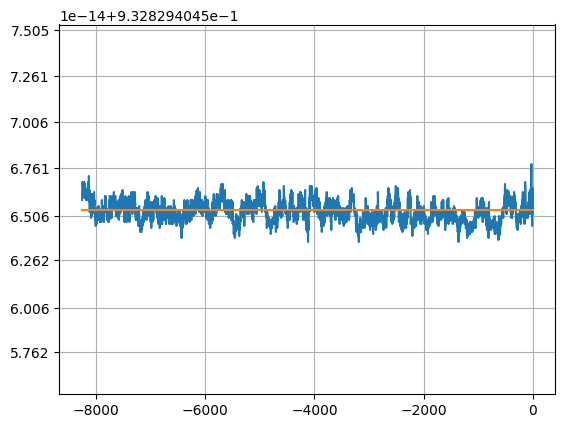

In [165]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

In [314]:
# parasitic error signal issues
aom20260203b = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260203_2.mat"
moku20260203b = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260203_124506.csv"
data20260203b = files2datawCEOmix(moku20260203b, aom20260203b, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260203b)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260203bserv = data20260203b.copy()
data20260203bserv.extend([aom20260203b, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20260203bserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0504112243652344
case 1
0.020548105239868164
matni:  0
matnf:  623
Done.
Start time:  2026-02-03 13:08:09.264995
End time:  2026-02-03 13:40:52.269003
623  data points
Duration:  1909.3704000000002
~~~ Uncertainty:  1.1442605137384398e-16  ~~~
------Comb Teeth------
1376720.9998612879585939873172690088109102877246472
1376721.0
1284245.9998706063735552726699285206308523483734654
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -14.09330486410100704797180055043743390334084888889
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998612879585939873172690088109102877246472
1376721.0
1284245.9998706063735552726699285206308523483734654
1284246.0
----------------------
oct exc fracs: 
0.4782958199356913 0.5168810289389068
0.30787781350482313 0.30385852090032156
Octupole Servo Error:  0.0670349346610311
Quad Servo Errors:  [0.01611856 0.04024941 0.02415937]


mpf('-20.633423531720042236990800346926514774807289045198918')

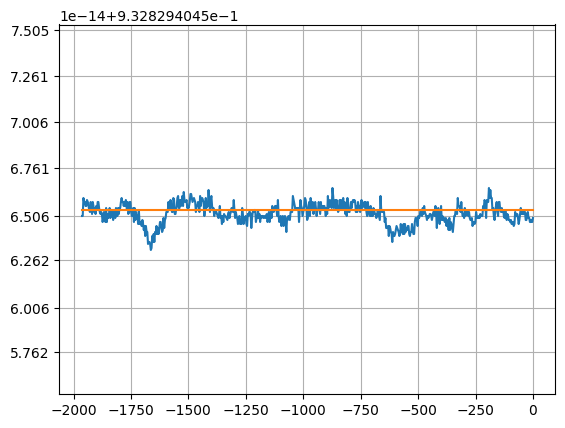

In [64]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

In [315]:
# !!!!-----------Rigol 10 MHz unlocked-------------!!!
aom20260203a = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260203_1.mat"
moku20260203a = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260203_095434.csv"
data20260203a = files2datawCEOmix(moku20260203a, aom20260203a, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260203a)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260203aserv = data20260203a.copy()
data20260203aserv.extend([aom20260203a, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20260203aserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0424296855926514
case 2
1.9391567707061768
matni:  0
matnf:  2286
Done.
Start time:  2026-02-03 10:14:22.694995
End time:  2026-02-03 12:15:46.943999
2286  data points
Duration:  7006.132800000001
~~~ Uncertainty:  5.973526873448237e-17  ~~~
------Comb Teeth------
1376720.9998618253220144036354306811172955156518594
1376721.0
1284245.9998711072386536450531324164407319301921812
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 17.9908080804159814337359078031741253118561496602
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998618253220144036354306811172955156518594
1376721.0
1284245.9998711072386536450531324164407319301921812
1284246.0
----------------------
oct exc fracs: 
0.48358862144420134 0.49321663019693657
0.3137855579868709 0.30919037199124727
Octupole Servo Error:  0.01672756626668239
Quad Servo Errors:  [0.06573879 0.04601298 0.05260444]


mpf('23.34460338752307709766010227883843687818125760362493')

In [66]:
##
aom20260202a = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260202_2.mat"
moku20260202a = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260202_162715.csv"
data20260202a = files2datawCEOmix(moku20260202a, aom20260202a, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260202a)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260202aserv = data20260202a.copy()
data20260202aserv.extend([aom20260202a, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20260202aserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0507960319519043
case 1
0.004224061965942383
matni:  0
matnf:  984
Done.
Start time:  2026-02-02 16:56:03.366002
End time:  2026-02-02 17:48:50.828997
984  data points
Duration:  3015.7632000000003
~~~ Uncertainty:  9.104820446748534e-17  ~~~
------Comb Teeth------
1376720.9998654746776320057451983045146377144431071
1376721.0
1284245.999874511641718985370005642083155823748164
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 3.1273220078802537745149236321014913740963799192164
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998654746776320057451983045146377144431071
1376721.0
1284245.999874511641718985370005642083155823748164
1284246.0
----------------------
oct exc fracs: 
0.49542217700915564 0.47965412004069174
0.31637843336724314 0.3209562563580875
Octupole Servo Error:  -0.02739708556232884
Quad Servo Errors:  [-0.07657271 -0.04585651 -0.04074602]


mpf('-0.5076808586963105987406565751296970178203719890840424')

In [316]:
aom20260130 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260130_1.mat"
moku20260130 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260130_112540.csv"
data20260130 = files2datawCEOmix(moku20260130, aom20260130, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260130)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260130serv = data20260130.copy()
data20260130serv.extend([aom20260130, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20260130serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.045475959777832
case 1
0.0021626949310302734
matni:  0
matnf:  4807
Done.
Start time:  2026-01-30 11:39:04.378999
End time:  2026-01-30 15:59:02.639002
4807  data points
Duration:  14732.493600000002
~~~ Uncertainty:  4.119380167545849e-17  ~~~
------Comb Teeth------
1376720.9998821132011902816883456046120587512741578
1376721.0
1284245.9998900326688504325447174333105880365506704
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -7.0000329524655442901625251774343562815465195710961
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998821132011902816883456046120587512741578
1376721.0
1284245.9998900326688504325447174333105880365506704
1284246.0
----------------------
oct exc fracs: 
0.49573449854348733 0.4953183520599251
0.3151269246774865 0.31491885143570536
Octupole Servo Error:  -0.0007228234043790508
Quad Servo Errors:  [0.00729478 0.00208373 0.00834012]


mpf('-6.0294516358194034806313369394997940281907332997927646')

In [68]:
### ------------- Wrong fringe !!! ----------
aom20260129 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260129_1.mat"
moku20260129 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260129_134616.csv"
data20260129 = files2datawCEOmix(moku20260129, aom20260129, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260129)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260129serv = data20260129.copy()
data20260129serv.extend([aom20260129, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20260129serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0551815032958984
case 1
0.0076563358306884766
matni:  0
matnf:  4452
Done.
Start time:  2026-01-29 14:14:28.749003
End time:  2026-01-29 18:12:25.324996
4452  data points
Duration:  13644.489600000003
~~~ Uncertainty:  4.2804690085299185e-17  ~~~
------Comb Teeth------
1376720.9998873538561024948581628951133221566951969
1376721.0
1284245.9998948848291494308353240362546992507961654
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 2834.1663474699736744868062950255667477983114963074
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998873538561024948581628951133221566951969
1376721.0
1284245.9998948848291494308353240362546992507961654
1284246.0
----------------------
oct exc fracs: 
0.5137047854414738 0.5011233430689732
0.31925410020220174 0.3185800943608178
Octupole Servo Error:  -0.021855032600429408
Quad Servo Errors:  [0.01126695 0.00675168 0.00900041]


mpf('2838.8782916465846324854664828763575274959614500805825')

In [317]:
aom20260128 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260128_1.mat"
moku20260128 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260128_125533.csv"
data20260128 = files2datawCEOmix(moku20260128, aom20260128, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260128)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260128serv = data20260128.copy()
data20260128serv.extend([aom20260128, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20260128serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 1
-4.999999523162842
case 1
0.014921426773071289
matni:  874
matnf:  6246
Done.
Start time:  2026-01-28 12:55:38
End time:  2026-01-28 18:04:28.507003
5372  data points
Duration:  16464.105600000003
~~~ Uncertainty:  3.8967355431289476e-17  ~~~
------Comb Teeth------
1376720.9998935712885595300617567849956238582958513
1376721.0
1284245.9999007210134592778992656476793971972213475
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 1.5124685124970419601836404270651649279548764379242
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998935712885595300617567849956238582958513
1376721.0
1284245.9999007210134592778992656476793971972213475
1284246.0
----------------------
oct exc fracs: 
0.49841742692236085 0.49236641221374045
0.32358964811022156 0.3251722211878607
Octupole Servo Error:  -0.01051036901023723
Quad Servo Errors:  [-0.01958767 -0.01586355 -0.01771731]


mpf('0.57463651104367291590543394795141957472368916300272981')

In [70]:
aom20260127b = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260127_2.mat"
moku20260127b = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260127_111629.csv"
data20260127b = files2datawCEOmix(moku20260127b, aom20260127b, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260127b)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260127bserv = data20260127b.copy()
data20260127bserv.extend([aom20260127b, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20260127bserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.051421642303467
case 1
0.026751279830932617
matni:  0
matnf:  1631
Done.
Start time:  2026-01-27 16:17:15.557999
End time:  2026-01-27 17:44:14.140003
1631  data points
Duration:  4998.688800000001
~~~ Uncertainty:  7.071995152670343e-17  ~~~
------Comb Teeth------
1376720.9998996263042124114815212053956811981323924
1376721.0
1284245.9999063692650321798633683482169862783108337
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 4.8751986534676190008185969976024815676546358918186
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998996263042124114815212053956811981323924
1376721.0
1284245.9999063692650321798633683482169862783108337
1284246.0
----------------------
oct exc fracs: 
0.49754601226993866 0.48865030674846627
0.31349693251533745 0.3156441717791411
Octupole Servo Error:  -0.015452455171192632
Quad Servo Errors:  [-0.0184502  -0.02150289 -0.01536119]


mpf('4.6031109113211437219860848159611259263480531616991588')

In [318]:
aom20260127a = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260127_1.mat"
moku20260127a = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260127_111629.csv"
data20260127a = files2datawCEOmix(moku20260127a, aom20260127a, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260127a)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260127aserv = data20260127a.copy()
data20260127aserv.extend([aom20260127a, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20260127aserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0424797534942627
case 1
0.01728200912475586
matni:  0
matnf:  4588
Done.
Start time:  2026-01-27 11:29:50.288995
End time:  2026-01-27 15:32:34.952995
4588  data points
Duration:  14061.302400000002
~~~ Uncertainty:  4.2165497636916665e-17  ~~~
------Comb Teeth------
1376720.9999003712443987687555945229504884243509563
1376721.0
1284245.9999070641732056537758777524741426175378291
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 4.5920125448761362448051628837343579200126563097479
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999003712443987687555945229504884243509563
1376721.0
1284245.9999070641732056537758777524741426175378291
1284246.0
----------------------
oct exc fracs: 
0.5019620667102681 0.4947678221059516
0.30673642903858733 0.3091345105733595
Octupole Servo Error:  -0.012495631864837927
Quad Servo Errors:  [-0.01747852 -0.02401281 -0.01968367]


mpf('3.5756463481819245155261683983560255964592932501072108')

In [72]:
aom20260126 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260126_1.mat"
moku20260126 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260126_112855.csv"
data20260126 = files2datawCEOmix(moku20260126, aom20260126, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260126)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260126serv = data20260126.copy()
data20260126serv.extend([aom20260126, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20260126serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0465898513793945
case 1
0.014303922653198242
matni:  0
matnf:  5915
Done.
Start time:  2026-01-26 12:12:06.516005
End time:  2026-01-26 17:36:02.664998
5915  data points
Duration:  18128.292
~~~ Uncertainty:  3.7135695355173464e-17  ~~~
------Comb Teeth------
1376720.9999049144172930849898490960659337505197032
1376721.0
1284245.9999113022711975796850403033654278482272332
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -3.2743879821237744077854981050676742785560922164848
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999049144172930849898490960659337505197032
1376721.0
1284245.9999113022711975796850403033654278482272332
1284246.0
----------------------
oct exc fracs: 
0.49847818735204596 0.4960263780858979
0.3101115995941833 0.31002705444707473
Octupole Servo Error:  -0.00425854523584054
Quad Servo Errors:  [-0.00507967  0.00084656 -0.00254219]


mpf('-2.93927869384064559238285852633439016372497251626908')

In [319]:
aom20260123b = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260123_2.mat"
moku20260123b = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260123_111316.csv"
data20260123b = files2datawCEOmix(moku20260123b, aom20260123b, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260123b)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260123bserv = data20260123b.copy()
data20260123bserv.extend([aom20260123b, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20260123bserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0639877319335938
case 1
0.006093263626098633
matni:  0
matnf:  3995
Done.
Start time:  2026-01-23 13:00:20.228000
End time:  2026-01-23 16:40:08.801003
3995  data points
Duration:  12243.876000000002
~~~ Uncertainty:  4.5186691385730253e-17  ~~~
------Comb Teeth------
1376720.9999207646427556873711722401652000460642546
1376721.0
1284245.9999260878452723750367292522203328392472916
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -4.5836023136530659352511303611479741417092750824768
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999207646427556873711722401652000460642546
1376721.0
1284245.9999260878452723750367292522203328392472916
1284246.0
----------------------
oct exc fracs: 
0.5056334501752628 0.4984977466199299
0.30683525287931895 0.3084626940410616
Octupole Servo Error:  -0.01239392977251629
Quad Servo Errors:  [-0.01756211 -0.01629621 -0.01631581]


mpf('-5.0830966860919561426837826736197597883200370672429461')

In [320]:
aom20260123a = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260123_1.mat"
moku20260123a = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260123_111316.csv"
data20260123a = files2datawCEOmix(moku20260123a, aom20260123a, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260123a)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260123aserv = data20260123a.copy()
data20260123aserv.extend([aom20260123a, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20260123aserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0645267963409424
case 1
0.023693084716796875
matni:  0
matnf:  1578
Done.
Start time:  2026-01-23 11:13:22.929997
End time:  2026-01-23 12:37:02.296003
1578  data points
Duration:  4836.254400000001
~~~ Uncertainty:  7.189777248508795e-17  ~~~
------Comb Teeth------
1376720.9999214456372594601275943889357594686441956
1376721.0
1284245.9999267230346750453668468056258606451848907
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 0.94996606543485268334897731115326483540526479350738
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999214456372594601275943889357594686441956
1376721.0
1284245.9999267230346750453668468056258606451848907
1284246.0
----------------------
oct exc fracs: 
0.5082435003170577 0.47970830691185795
0.31103360811667724 0.31769181991122386
Octupole Servo Error:  -0.049572501679699295
Quad Servo Errors:  [-0.0825876  -0.06667718 -0.07313729]


mpf('-2.099596686709590224235711768490589429845365904720148')

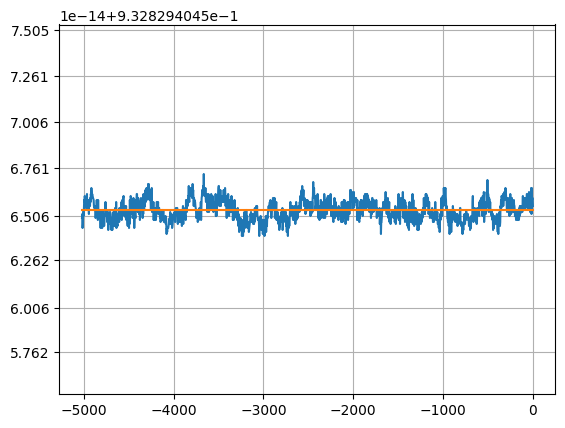

In [75]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

In [321]:
aom20260122 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260122_2.mat"
moku20260122 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260122_130811.csv"
data20260122 = files2datawCEOmix(moku20260122, aom20260122, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260122)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260122serv = data20260122.copy()
data20260122serv.extend([aom20260122, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20260122serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.055987596511841
case 1
0.009902477264404297
matni:  0
matnf:  969
Done.
Start time:  2026-01-22 13:21:40.624002
End time:  2026-01-22 14:12:13.240997
969  data points
Duration:  2969.7912000000006
~~~ Uncertainty:  9.175020564262711e-17  ~~~
------Comb Teeth------
1376720.9999260451502056064382316376311421951684473
1376721.0
1284245.9999310136133158643068660454087129121389349
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -0.66823194148024284924757831909009190192780039012416
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999260451502056064382316376311421951684473
1376721.0
1284245.9999310136133158643068660454087129121389349
1284246.0
----------------------
oct exc fracs: 
0.4994834710743802 0.4984504132231405
0.309400826446281 0.3130165289256198
Octupole Servo Error:  -0.0017942884190283814
Quad Servo Errors:  [-0.03105117 -0.03620485 -0.05173553]


mpf('-6.1508872916015485359085400433912265658064383145864798')

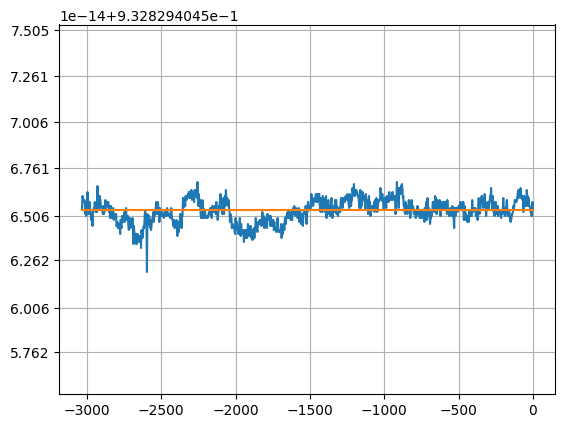

In [77]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

In [322]:
aom20260121 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20260121_1.mat"
moku20260121 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20260121_114747.csv"
data20260121 = files2datawCEOmix(moku20260121, aom20260121, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20260121)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20260121serv = data20260121.copy()
data20260121serv.extend([aom20260121, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20260121serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.052396535873413
case 1
0.01122283935546875
matni:  0
matnf:  2982
Done.
Start time:  2026-01-21 12:52:19.119998
End time:  2026-01-21 15:34:59.725002
2982  data points
Duration:  9139.233600000001
~~~ Uncertainty:  5.2301616904642914e-17  ~~~
------Comb Teeth------
1376720.9999306907905725676579094239538530676819701
1376721.0
1284245.9999353471606669358346024643225974927486122
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 2.659508701552907767680861925605973364171481869021
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999306907905725676579094239538530676819701
1376721.0
1284245.9999353471606669358346024643225974927486122
1284246.0
----------------------
oct exc fracs: 
0.5060382422006038 0.48809124454880914
0.304260315330426 0.3156658839315666
Octupole Servo Error:  -0.031173841145126023
Quad Servo Errors:  [-0.11592605 -0.11421147 -0.11947732]


mpf('-9.4155411273718178372615226668285870869074209583728156')

In [79]:
aom20251219 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251219_1.mat"
moku20251219 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251219_103552.csv"
data20251219 = files2datawCEOmixw729(moku20251219, aom20251219, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251219)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251219serv = data20251219.copy()
data20251219serv.extend([aom20251219, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20251219serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

42465949.689868346
25381759.1632588
Trimming.....
case 2
-3.057403326034546
case 1
0.008363723754882812
matni:  0
matnf:  6456
Done.
Start time:  2025-12-19 10:48:42.406998
End time:  2025-12-19 16:36:38.250998
6456  data points
Duration:  19786.348800000003
~~~ Uncertainty:  3.5545708413852904e-17  ~~~
------Comb Teeth------
1376720.9999344990906834216541518572219984611779265
1376721.0
1284245.9999388997175679760067029198327344864761252
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -1.9193791339110166460103433462659314594234289256846
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999344990906834216541518572219984611779265
1376721.0
1284245.9999388997175679760067029198327344864761252
1284246.0
----------------------
oct exc fracs: 
0.49899302865995354 0.49783113865220757
0.3126258714175058 0.31324554608830363
Octupole Servo Error:  -0.0020180607207599837
Quad Servo Errors:  [ 0.00232722 -0.00620514  0.        ]


mpf('-1.7928842628208285842790658472066067036437441791103302')

In [323]:
# ----!!!!! Ratio Lock was Off !!!!!!!!!! -------------
aom20251218a = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251218_1.mat"
moku20251218a = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251218_104637.csv"
data20251218a = files2datawCEOmixw729(moku20251218a, aom20251218a, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251218a)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251218aserv = data20251218a.copy()
data20251218aserv.extend([aom20251218a, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251218aserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

42464750.87990148
25382878.285324927
Trimming.....
case 2
-3.0437726974487305
case 1
0.013492345809936523
matni:  0
matnf:  3950
Done.
Start time:  2025-12-18 10:59:09.784001
End time:  2025-12-18 14:28:23.171001
3950  data points
Duration:  12105.960000000001
~~~ Uncertainty:  4.5443354997837534e-17  ~~~
------Comb Teeth------
1376720.9999390271221450625671659063348767600814993
1376721.0
1284245.9999431235332472122440845306072653781396725
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 2.4516182754338362728874673947077533593994346802273
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999390271221450625671659063348767600814993
1376721.0
1284245.9999431235332472122440845306072653781396725
1284246.0
----------------------
oct exc fracs: 
0.4955684983540137 0.4939225120283616
0.3079260572296784 0.30830590022790577
Octupole Servo Error:  -0.002859034737813642
Quad Servo Errors:  [ 0.         -0.00380347 -0.00761713]


mpf('2.3438320656045359512671394795404845266533128229814423')

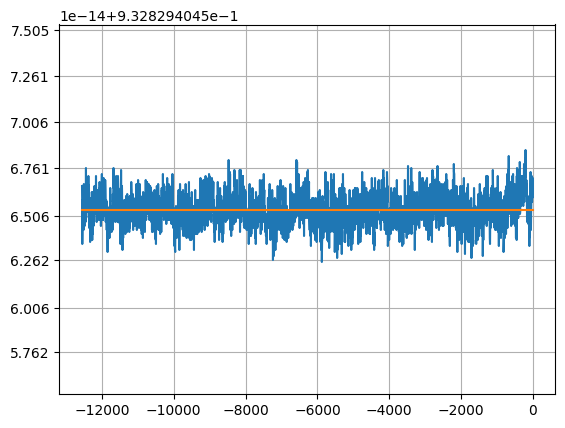

In [81]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

In [324]:
aom20251217 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251217_1.mat"
moku20251217 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251217_100221.csv"
data20251217 = files2datawCEOmixw729(moku20251217, aom20251217, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251217)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251217serv = data20251217.copy()
data20251217serv.extend([aom20251217, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251217serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

42462817.341434374
25384687.20081344
Trimming.....
case 2
-3.0607168674468994
case 1
0.0005877017974853516
matni:  0
matnf:  10108
Done.
Start time:  2025-12-17 10:14:46.070004
End time:  2025-12-17 19:22:13.763995
10108  data points
Duration:  30978.998400000004
~~~ Uncertainty:  2.840771604412062e-17  ~~~
------Comb Teeth------
1376720.9999459608306366730813406493090264582221304
1376721.0
1284245.9999495916509119286191754595955143977130758
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -8.7073969860899548897216407395034759193864139474728
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999459608306366730813406493090264582221304
1376721.0
1284245.9999495916509119286191754595955143977130758
1284246.0
----------------------
oct exc fracs: 
0.4900069258929455 0.4964381121994657
0.30741070545166715 0.3066191748293262
Octupole Servo Error:  0.01117130471444357
Quad Servo Errors:  [0.00743073 0.00792604 0.00297708]


mpf('-9.5593425543972513494637579964248572854617783400481907')

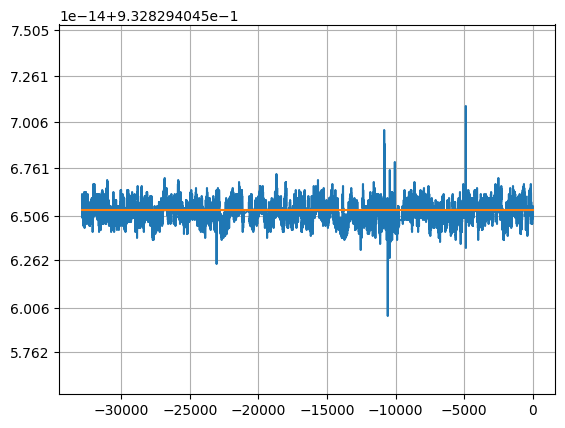

In [83]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

In [325]:
aom20251216b = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251216_1.mat"
moku20251216b = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251216_153204.csv"
data20251216b = files2datawCEOmixw729(moku20251216b, aom20251216b, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251216b)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251216bserv = data20251216b.copy()
data20251216bserv.extend([aom20251216b, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251216bserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

42461928.07564004
25385516.458897863
Trimming.....
case 1
-3.6829962730407715
case 1
0.015815258026123047
matni:  5031
matnf:  8777
Done.
Start time:  2025-12-16 15:32:07.682996
End time:  2025-12-16 18:51:26.515003
3746  data points
Duration:  11480.740800000001
~~~ Uncertainty:  4.6664331467736086e-17  ~~~
------Comb Teeth------
1376720.9999507703385744322405762667700604698325978
1376721.0
1284245.9999540780428894165578029940834978371111181
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -4.1109289591609274788318729559130001414127195771532
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999507703385744322405762667700604698325978
1376721.0
1284245.9999540780428894165578029940834978371111181
1284246.0
----------------------
oct exc fracs: 
0.4891855807743658 0.4931909212283044
0.30801068090787714 0.30694259012016023
Octupole Servo Error:  0.006957915296341049
Quad Servo Errors:  [0.00802682 0.01069525 0.01338028]


mpf('-3.6399759580791028016336337511106260904889029225831819')

In [85]:
aom20251216a = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251216_1.mat"
moku20251216a = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251216_113534.csv"
data20251216a = files2datawCEOmixw729(moku20251216a, aom20251216a, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251216a)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251216aserv = data20251216a.copy()
data20251216aserv.extend([aom20251216a, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20251216aserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

42461818.32715419
25385619.381737
Trimming.....
case 1
-4.459003686904907
case 2
0.774167537689209
matni:  551
matnf:  2939
Done.
Start time:  2025-12-16 11:35:38.459004
End time:  2025-12-16 13:40:57.928005
2388  data points
Duration:  7318.742400000001
~~~ Uncertainty:  5.844559356447891e-17  ~~~
------Comb Teeth------
1376720.9999512376722795991208282861721255065862522
1376721.0
1284245.999954513981756030839476284548588048075233
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -3.5779263721448161145143167315383953818183252688982
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999512376722795991208282861721255065862522
1376721.0
1284245.999954513981756030839476284548588048075233
1284246.0
----------------------
oct exc fracs: 
0.49455383326351066 0.4935064935064935
0.3135735232509426 0.3131545873481357
Octupole Servo Error:  -0.0018192319269798075
Quad Servo Errors:  [-0.00419485  0.00419509 -0.01680518]


mpf('-4.1083767674794518029979907939610105169788581949033956')

In [326]:
aom20251215 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251215_2.mat"
moku20251215 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251215_111421.csv"
data20251215 = files2datawCEOmixw729(moku20251215, aom20251215, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251215)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251215serv = data20251215.copy()
data20251215serv.extend([aom20251215, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251215serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

42461275.67382747
25386125.68256049
Trimming.....
case 2
-3.0539121627807617
case 1
0.01687312126159668
matni:  0
matnf:  4074
Done.
Start time:  2025-12-15 15:19:58.663997
End time:  2025-12-15 18:54:17.006997
4074  data points
Duration:  12485.995200000001
~~~ Uncertainty:  4.474643316887411e-17  ~~~
------Comb Teeth------
1376720.9999531351168975751894121041122323410715986
1376721.0
1284245.9999562839930660267822210697445813360293627
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -5.2512310521892137016049746062242576228365408177923
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999531351168975751894121041122323410715986
1376721.0
1284245.9999562839930660267822210697445813360293627
1284246.0
----------------------
oct exc fracs: 
0.5094524920206236 0.4926344218021115
0.3126687945003683 0.31684262214583847
Octupole Servo Error:  -0.02921211576025685
Quad Servo Errors:  [-0.03811114 -0.04179816 -0.03812604]


mpf('-6.4177016968461950228149670514942245100450995912736092')

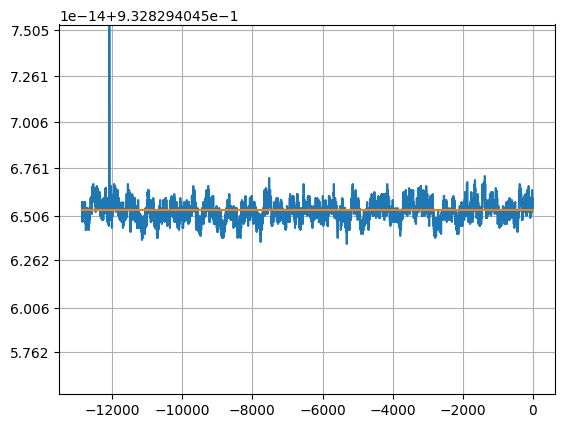

In [87]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

In [327]:
aom20251212 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251212_1.mat"
moku20251212 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251212_124324.csv"
data20251212 = files2datawCEOmixw729(moku20251212, aom20251212, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251212)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251212serv = data20251212.copy()
data20251212serv.extend([aom20251212, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251212serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

42458810.17504899
25388437.182698455
Trimming.....
case 2
-3.0595457553863525
case 1
0.021368741989135742
matni:  0
matnf:  6371
Done.
Start time:  2025-12-12 12:54:13.130001
End time:  2025-12-12 18:34:59.140002
6371  data points
Duration:  19525.8408
~~~ Uncertainty:  3.578204292011291e-17  ~~~
------Comb Teeth------
1376720.9999633757944385466717276850681463253182182
1376721.0
1284245.9999658366741660578677916602230963698268718
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 4.6920154270740313692216534995596091703403193939902
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999633757944385466717276850681463253182182
1376721.0
1284245.9999658366741660578677916602230963698268718
1284246.0
----------------------
oct exc fracs: 
0.5047095761381476 0.49960753532182106
0.31020408163265306 0.3108320251177394
Octupole Servo Error:  -0.008861651076059844
Quad Servo Errors:  [-0.00786228 -0.00628767 -0.00944168]


mpf('4.9296640562319002439050805866158511261684281525085312')

In [89]:
aom20251211 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251211_1.mat"
moku20251211 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251211_103628.csv"
data20251211 = files2datawCEOmixw729(moku20251211, aom20251211, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251211)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251211serv = data20251211.copy()
data20251211serv.extend([aom20251211, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20251211serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

42458020.75667833
25389179.304746713
Trimming.....
case 2
-3.061840534210205
case 1
0.0049054622650146484
matni:  0
matnf:  10235
Done.
Start time:  2025-12-11 10:47:11.521995
End time:  2025-12-11 19:45:52.056997
10235  data points
Duration:  31368.228000000003
~~~ Uncertainty:  2.823091870104356e-17  ~~~
------Comb Teeth------
1376720.9999658834384805144819555657637276579736214
1376721.0
1284245.999968175945646330349325247630732752277676
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -0.72423172393733857195880066100826657227139004662164
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999658834384805144819555657637276579736214
1376721.0
1284245.999968175945646330349325247630732752277676
1284246.0
----------------------
oct exc fracs: 
0.5054230994723471 0.4946746140316592
0.31111979675591167 0.31380691811608363
Octupole Servo Error:  -0.018669024674380925
Quad Servo Errors:  [-0.02887759 -0.02690733 -0.02839986]


mpf('-1.8934272033179607428001955572035277102378958276288724')

In [328]:
aom20251210 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251210_1_a.mat"
moku20251210 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251210_121146.csv"
data20251210 = files2datawCEOmixw729(moku20251210, aom20251210, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251210)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251210serv = data20251210.copy()
data20251210serv.extend([aom20251210, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251210serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

42456430.36440267
25390663.367086396
Trimming.....
case 2
-3.0556142330169678
case 1
0.0152587890625
matni:  0
matnf:  3104
Done.
Start time:  2025-12-10 12:18:09.884996
End time:  2025-12-10 15:03:21.424003
3104  data points
Duration:  9513.139200000001
~~~ Uncertainty:  5.126347926891207e-17  ~~~
------Comb Teeth------
1376720.9999728609964719448926574045600870292871358
1376721.0
1284245.9999746848461799107126874060741129340533791
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -2.8712600527993815976168446172041701196135263399748
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999728609964719448926574045600870292871358
1376721.0
1284245.9999746848461799107126874060741129340533791
1284246.0
----------------------
oct exc fracs: 
0.5053174347405737 0.49323235578472446
0.323396712858524 0.32597486303577183
Octupole Servo Error:  -0.02099070169614721
Quad Servo Errors:  [-0.02906564 -0.02584435 -0.03873463]


mpf('-4.1369787525441083106017224626860423147980762687965321')

In [91]:
aom20251209 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251209_1.mat"
moku20251209 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251209_095441.csv"
data20251209 = files2datawCEOmixw729(moku20251209, aom20251209, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251209)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251209serv = data20251209.copy()
data20251209serv.extend([aom20251209, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20251209serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

42454692.30780625
25392282.110057175
Trimming.....
case 2
-3.0470056533813477
case 1
0.0034863948822021484
matni:  0
matnf:  9976
Done.
Start time:  2025-12-09 10:01:19.183997
End time:  2025-12-09 19:05:27.656005
9976  data points
Duration:  30574.444800000005
~~~ Uncertainty:  2.859504040953522e-17  ~~~
------Comb Teeth------
1376720.9999790285685178962298675583116122990424975
1376721.0
1284245.9999804380725603770539464483310072392688694
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 2.5170554419683107725923293531733579330723199249967
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999790285685178962298675583116122990424975
1376721.0
1284245.9999804380725603770539464483310072392688694
1284246.0
----------------------
oct exc fracs: 
0.49468671679197995 0.4924310776942356
0.3076691729323308 0.30781954887218044
Octupole Servo Error:  -0.00391810197646529
Quad Servo Errors:  [-0.00200926 -0.00150577  0.00251061]


mpf('3.0785973286372510988434188591932232774871314291112027')

In [329]:
aom20251208 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251208_1.mat"
moku20251208 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251208_100152.csv"
data20251208 = files2datawCEOmixw729(moku20251208, aom20251208, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251208)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251208serv = data20251208.copy()
data20251208serv.extend([aom20251208, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251208serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

42453549.0715628
25393347.611673
Trimming.....
case 1
-3.16300106048584
case 2
7.679077863693237
matni:  237
matnf:  5391
Done.
Start time:  2025-12-08 10:01:55.163001
End time:  2025-12-08 15:03:21.272998
5154  data points
Duration:  15795.979200000002
~~~ Uncertainty:  3.978292653058819e-17  ~~~
------Comb Teeth------
1376720.9999843568520533862317988048146286594504639
1376721.0
1284245.9999854083955178165619075134669034732020929
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 6.5730688643864234505017712659279095784716834748611
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999843568520533862317988048146286594504639
1376721.0
1284245.9999854083955178165619075134669034732020929
1284246.0
----------------------
oct exc fracs: 
0.5029109256743645 0.492140500679216
0.31185717058024454 0.3162235590917912
Octupole Servo Error:  -0.01870742413726894
Quad Servo Errors:  [-0.03401423 -0.04372513 -0.0359859 ]


mpf('3.9793752245199608278402281178861149787095273075563164')

In [93]:
aom20251205 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251205_1.mat"
moku20251205 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251205_093538.csv"
data20251205 = files2datawCEOmixw729(moku20251205, aom20251205, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251205)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251205serv = data20251205.copy()
data20251205serv.extend([aom20251205, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20251205serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

42450419.78205527
25396278.519127514
Trimming.....
case 1
-36.59800171852112
case 1
0.009584665298461914
matni:  11
matnf:  8661
Done.
Start time:  2025-12-05 09:36:14.598002
End time:  2025-12-05 17:17:16.664004
8650  data points
Duration:  26510.520000000004
~~~ Uncertainty:  3.070866106699773e-17  ~~~
------Comb Teeth------
1376720.9999969484950333826550076310532667930714192
1376721.0
1284245.9999971543187119408274441420909893266674034
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 1.5783710139132759444987712908142655129091421088673
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999969484950333826550076310532667930714192
1376721.0
1284245.9999971543187119408274441420909893266674034
1284246.0
----------------------
oct exc fracs: 
0.5025436466643542 0.4967626315180946
0.3140825528962886 0.31627933865186725
Octupole Servo Error:  -0.010040904733244883
Quad Servo Errors:  [-0.0191209  -0.02199974 -0.01968768]


mpf('0.19747668864454613526138571786288355049564660614108534')

In [330]:
aom20251202 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251202_1.mat"
moku20251202 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251202_095859.csv"
data20251202 = files2datawCEOmixw729(moku20251202, aom20251202, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251202)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251202serv = data20251202.copy()
data20251202serv.extend([aom20251202, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251202serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

42498458.16557969
25351465.27498533
Trimming.....
case 2
-3.046635866165161
case 1
0.002706289291381836
matni:  0
matnf:  9838
Done.
Start time:  2025-12-02 10:12:02.818003
End time:  2025-12-02 19:22:05.276997
9838  data points
Duration:  30151.502400000005
~~~ Uncertainty:  2.8794896757953066e-17  ~~~
------Comb Teeth------
1376720.999804669967064857359884935516433423096968
1376721.0
1284245.9998177913117983988838115420622701519053584
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -5.3948024175909722178933034072270705605923461276935
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.999804669967064857359884935516433423096968
1376721.0
1284245.9998177913117983988838115420622701519053584
1284246.0
----------------------
oct exc fracs: 
0.4974585747687303 0.4984243163566128
0.314069330080309 0.3139676730710583
Octupole Servo Error:  0.0016773816073175562
Quad Servo Errors:  [0.00050957 0.00101799 0.        ]


mpf('-5.5820557445537799612447090825404193637299531054536124')

In [95]:
aom20251201 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251201_1.mat"
moku20251201 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251201_143704.csv"
data20251201 = files2datawCEOmixw729(moku20251201, aom20251201, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251201)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251201serv = data20251201.copy()
data20251201serv.extend([aom20251201, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20251201serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

42497653.713030666
25352216.108616155
Trimming.....
case 2
-3.0595102310180664
case 1
0.023340463638305664
matni:  0
matnf:  6268
Done.
Start time:  2025-12-01 15:03:20.654997
End time:  2025-12-01 20:36:14.673000
6268  data points
Duration:  19210.166400000002
~~~ Uncertainty:  3.6074842273814076e-17  ~~~
------Comb Teeth------
1376720.9998084937517429931486679741488308418431305
1376721.0
1284245.999821359682447940517824984643308509842689
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -120.57550698578205849652709820558634743604214429732
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998084937517429931486679741488308418431305
1376721.0
1284245.999821359682447940517824984643308509842689
1284246.0
----------------------
oct exc fracs: 
0.4944949736716132 0.49728737833093983
0.31314823679591514 0.31147279400031913
Octupole Servo Error:  0.00485022576476817
Quad Servo Errors:  [0.01278562 0.01677685 0.01038786]


mpf('-119.39628145884878834745539685184971872837790111724323')

In [331]:
aom20251126 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251126_1.mat"
moku20251126 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251126_134209.csv"
data20251126 = files2datawCEOmix(moku20251126, aom20251126, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251126)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251126serv = data20251126.copy()
data20251126serv.extend([aom20251126, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251126serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 1
-5.538995027542114
case 1
0.008829593658447266
matni:  244
matnf:  6465
Done.
Start time:  2025-11-26 13:42:14.538995
End time:  2025-11-26 19:21:26.304003
6221  data points
Duration:  19066.120800000004
~~~ Uncertainty:  3.621085956966482e-17  ~~~
------Comb Teeth------
1376720.9998256924922521950122640522930534418211754
1376721.0
1284245.9998374017337674863426450341681108282124662
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -3.9971832359646931512722638094599850174260717676674
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998256924922521950122640522930534418211754
1376721.0
1284245.9998374017337674863426450341681108282124662
1284246.0
----------------------
oct exc fracs: 
0.502411575562701 0.49316720257234725
0.31816720257234726 0.3214630225080386
Octupole Servo Error:  -0.0160566586780785
Quad Servo Errors:  [-0.02738229 -0.03301806 -0.0313937 ]


mpf('-5.9416868215696661179941269678333740347573895833815651')

In [97]:
aom20251124b = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251124_3.mat"
moku20251124b = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251124_171928.csv"
data20251124b = files2datawCEOmixw729(moku20251124b, aom20251124b, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251124b)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251124bserv = data20251124b.copy()
data20251124bserv.extend([aom20251124b, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20251124bserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

42491514.4805927
25357955.4877037
Trimming.....
case 1
-4.590997695922852
case 1
0.014234066009521484
matni:  4720
matnf:  6984
Done.
Start time:  2025-11-24 17:19:32.590998
End time:  2025-11-24 19:18:31.267998
2264  data points
Duration:  6938.707200000001
~~~ Uncertainty:  6.00248002638574e-17  ~~~
------Comb Teeth------
1376720.9998333322948601231383630959535471248040624
1376721.0
1284245.9998445283026714849187522423394527740283298
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 1.2837863407891672379552736283924316919236604100401
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998333322948601231383630959535471248040624
1376721.0
1284245.9998445283026714849187522423394527740283298
1284246.0
----------------------
oct exc fracs: 
0.5083959346000884 0.4942554131683606
0.3075563411400795 0.3144056562085727
Octupole Servo Error:  -0.024561036576099725
Quad Servo Errors:  [-0.05089297 -0.06858457 -0.04431958]


mpf('-2.8230008805510107125636635011371633785545640429813791')

In [332]:
aom20251124a = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251124_2.mat"
moku20251124a = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251124_121926.csv"
data20251124a = files2datawCEOmix(moku20251124a, aom20251124a, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251124a)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251124aserv = data20251124a.copy()
data20251124aserv.extend([aom20251124a, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251124aserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 1
-4.207995891571045
case 1
0.02505016326904297
matni:  82
matnf:  719
Done.
Start time:  2025-11-24 12:19:30.207996
End time:  2025-11-24 12:53:39.023005
637  data points
Duration:  1952.2776000000003
~~~ Uncertainty:  1.1316163630482371e-16  ~~~
------Comb Teeth------
1376720.9998339271070913247651655737639191333349012
1376721.0
1284245.9998450832757764557999887043790481560250696
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -7.8330275769565650370163079237260229667381292699357
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998339271070913247651655737639191333349012
1376721.0
1284245.9998450832757764557999887043790481560250696
1284246.0
----------------------
oct exc fracs: 
0.5062893081761006 0.5031446540880503
0.30974842767295596 0.3081761006289308
Octupole Servo Error:  -0.0054620573206757925
Quad Servo Errors:  [-0.01579822  0.01574396 -0.0315637 ]


mpf('-8.5134813645408919387607750810810418772626681979971635')

In [99]:
aom20251121 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251121_1.mat"
moku20251121 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251121_111407.csv"
data20251121 = files2datawCEOmix(moku20251121, aom20251121, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251121)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251121serv = data20251121.copy()
data20251121serv.extend([aom20251121, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20251121serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.046680450439453
case 1
0.012280941009521484
matni:  0
matnf:  8247
Done.
Start time:  2025-11-21 11:40:08.743999
End time:  2025-11-21 19:05:06.933003
8247  data points
Duration:  25275.405600000002
~~~ Uncertainty:  3.145002084037957e-17  ~~~
------Comb Teeth------
1376720.9998463563079492971001482149295590809819122
1376721.0
1284245.9998566774954816955128710162306426506747938
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 0.55185495107204741254503126311852405363224341771339
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998463563079492971001482149295590809819122
1376721.0
1284245.9998566774954816955128710162306426506747938
1284246.0
----------------------
oct exc fracs: 
0.5004244482173175 0.4973320397768615
0.32173174872665533 0.3222774678632064
Octupole Servo Error:  -0.005371125416807627
Quad Servo Errors:  [-0.00668804 -0.00546844 -0.00667951]


mpf('0.4761996844835177987820502440759725833021312696423472')

In [333]:
aom20251120 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251120_1_a.mat"
moku20251120 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251120_151426.csv"
data20251120 = files2datawCEOmix(moku20251120, aom20251120, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251120)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251120serv = data20251120.copy()
data20251120serv.extend([aom20251120, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251120serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0434508323669434
case 1
0.0013439655303955078
matni:  0
matnf:  337
Done.
Start time:  2025-11-20 15:27:17.601005
End time:  2025-11-20 15:44:48.058001
337  data points
Duration:  1032.8376
~~~ Uncertainty:  1.5558007783035786e-16  ~~~
------Comb Teeth------
1376720.9998506054009219977877514814021135241362086
1376721.0
1284245.9998606412782254332892462911866181295556658
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -7.641805471504789618054838887266417694282970560974
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998506054009219977877514814021135241362086
1376721.0
1284245.9998606412782254332892462911866181295556658
1284246.0
----------------------
oct exc fracs: 
0.5148809523809523 0.4955357142857143
0.31547619047619047 0.31398809523809523
Octupole Servo Error:  -0.03360375501649132
Quad Servo Errors:  [ 0.03008749  0.01490219 -0.02984509]


mpf('-1.6751989906026567120175492622799420254517010837229835')

In [101]:
# -----------------------Ratio Lock Broken all day !!! ----------------------
aom20251119 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251119_1.mat"
moku20251119 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251119_102454.csv"
data20251119 = files2datawCEOmix(moku20251119, aom20251119, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251119)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251119serv = data20251119.copy()
data20251119serv.extend([aom20251119, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20251119serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0611698627471924
case 1
0.0036292076110839844
matni:  0
matnf:  5825
Done.
Start time:  2025-11-19 10:31:20.387001
End time:  2025-11-19 16:23:22.950997
5825  data points
Duration:  17852.460000000003
~~~ Uncertainty:  3.7421480894039974e-17  ~~~
------Comb Teeth------
1376720.9998549314144393425813124213469245756480928
1376721.0
1284245.9998646767231756462269360985379580377329401
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -2.1286371933830181332379711192282790794033799628853
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998549314144393425813124213469245756480928
1376721.0
1284245.9998646767231756462269360985379580377329401
1284246.0
----------------------
oct exc fracs: 
0.49364697802197804 0.49047046703296704
0.3166208791208791 0.3166208791208791
Octupole Servo Error:  -0.005517933434782455
Quad Servo Errors:  [0.00430133 0.         0.00257897]


mpf('-0.93613525417957959719824105432170499826295254999671106')

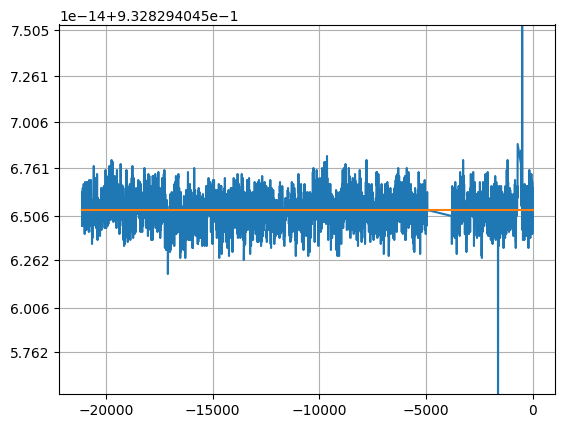

In [102]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

In [334]:
aom20251117 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251117_1_b.mat"
moku20251117 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251117_101204.csv"
data20251117 = files2datawCEOmix(moku20251117, aom20251117, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251117)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251117serv = data20251117.copy()
data20251117serv.extend([aom20251117, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251117serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.042870044708252
case 1
0.007448673248291016
matni:  0
matnf:  6987
Done.
Start time:  2025-11-17 10:24:33.883996
End time:  2025-11-17 16:41:31.298996
6987  data points
Duration:  21413.757600000004
~~~ Uncertainty:  3.4168315078203354e-17  ~~~
------Comb Teeth------
1376720.9998636027671404760950423871716955830116806
1376721.0
1284245.9998727655218000578407711391918311817455739
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -1.0964660130432529845499082722429227723442796855027
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998636027671404760950423871716955830116806
1376721.0
1284245.9998727655218000578407711391918311817455739
1284246.0
----------------------
oct exc fracs: 
0.5037933008874893 0.4903378184941311
0.31248210707128543 0.3177068422559404
Octupole Servo Error:  -0.023371552505556687
Quad Servo Errors:  [-0.05093111 -0.05232345 -0.05375302]


mpf('-5.0597159965689592572942452485917328050618718707072446')

In [104]:
aom20251114b = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251114_1.mat"
moku20251114b = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251114_122752.csv"
data20251114b = files2datawCEOmix(moku20251114b, aom20251114b, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251114b)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251114bserv = data20251114b.copy()
data20251114bserv.extend([aom20251114b, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20251114bserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 1
-4.708004713058472
case 1
0.011670827865600586
matni:  1798
matnf:  8004
Done.
Start time:  2025-11-14 12:27:56.708005
End time:  2025-11-14 17:59:31.054995
6206  data points
Duration:  19020.148800000003
~~~ Uncertainty:  3.625459426844555e-17  ~~~
------Comb Teeth------
1376720.9998736496804470326237724615768693528142198
1376721.0
1284245.9998821375932636765474889800946775847505173
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -2.2406213164298327386138605022930807976342060842283
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998736496804470326237724615768693528142198
1376721.0
1284245.9998821375932636765474889800946775847505173
1284246.0
----------------------
oct exc fracs: 
0.500402900886382 0.49411764705882355
0.31257050765511685 0.3145044319097502
Octupole Servo Error:  -0.010916911437041214
Quad Servo Errors:  [-0.02748852 -0.01936586 -0.02341219]


mpf('-3.9431013807521978225441898673213606200578561807744515')

In [335]:
aom20251114 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251114_1_a.mat"
moku20251114 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251114_103938.csv"
data20251114 = files2datawCEOmix(moku20251114, aom20251114, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251114)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251114serv = data20251114.copy()
data20251114serv.extend([aom20251114, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251114serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0636236667633057
case 2
2.590005874633789
matni:  0
matnf:  1792
Done.
Start time:  2025-11-14 10:52:15.582003
End time:  2025-11-14 12:27:35.253997
1792  data points
Duration:  5492.1216
~~~ Uncertainty:  6.74683256047865e-17  ~~~
------Comb Teeth------
1376720.9998741551874845900817519619295632444096315
1376721.0
1284245.999882609207721998806644781740074982836236
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -7.1685792652787529816923616263879188322825742992264
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998741551874845900817519619295632444096315
1376721.0
1284245.999882609207721998806644781740074982836236
1284246.0
----------------------
oct exc fracs: 
0.4980457844779453 0.5069793411501954
0.3269123394751535 0.3305415968732552
Octupole Servo Error:  0.015516731446176974
Quad Servo Errors:  [ 0.         -0.03640679 -0.00838618]


mpf('-11.754127838835265636474360727833742276960309285378243')

In [106]:
aom20251113 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251113_1.mat"
moku20251113 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251113_105105.csv"
data20251113 = files2datawCEOmix(moku20251113, aom20251113, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251113)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251113serv = data20251113.copy()
data20251113serv.extend([aom20251113, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20251113serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0539090633392334
case 1
0.012309551239013672
matni:  0
matnf:  9449
Done.
Start time:  2025-11-13 11:01:44.407001
End time:  2025-11-13 19:20:48.215003
9449  data points
Duration:  28959.295200000004
~~~ Uncertainty:  2.938163845302812e-17  ~~~
------Comb Teeth------
1376720.9998776158705332076878968859946531696951045
1376721.0
1284245.9998858373295950044614665045884334212371276
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 1.1940367701635727653814698754138346244663161543199
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998776158705332076878968859946531696951045
1376721.0
1284245.9998858373295950044614665045884334212371276
1284246.0
----------------------
oct exc fracs: 
0.4986240474174429 0.4927497883149873
0.31747459779847587 0.3195385266723116
Octupole Servo Error:  -0.010203290351510626
Quad Servo Errors:  [-0.02122143 -0.02067413 -0.02172886]


mpf('-0.29793815054218975230288163936675255166461388785824812')

In [336]:
aom20251112 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251112_1.mat"
moku20251112 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251112_101514.csv"
data20251112 = files2datawCEOmix(moku20251112, aom20251112, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251112)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251112serv = data20251112.copy()
data20251112serv.extend([aom20251112, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251112serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.064136028289795
case 1
0.025568485260009766
matni:  0
matnf:  13186
Done.
Start time:  2025-11-12 10:29:11.281003
End time:  2025-11-12 22:08:45.940002
13186  data points
Duration:  40412.45280000001
~~~ Uncertainty:  2.487209679258613e-17  ~~~
------Comb Teeth------
1376720.9998811756096208088602366786516959748420927
1376721.0
1284245.9998891580392926305266111366461774203476935
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -5.1925575461530524034385118461491046278167203767859
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998811756096208088602366786516959748420927
1376721.0
1284245.9998891580392926305266111366461774203476935
1284246.0
----------------------
oct exc fracs: 
0.4974971558589306 0.49764884338263177
0.31683731513083047 0.3172544558210087
Octupole Servo Error:  0.00026346466972099967
Quad Servo Errors:  [-0.0030401  -0.00417795 -0.00417715]


mpf('-5.7853934811538768954190991343004615329984182610455169')

In [108]:
aom20251111 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251111_1.mat"
moku20251111 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251111_101227.csv"
data20251111 = files2datawCEOmix(moku20251111, aom20251111, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251111)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251111serv = data20251111.copy()
data20251111serv.extend([aom20251111, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20251111serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0583295822143555
case 1
0.014178752899169922
matni:  0
matnf:  10108
Done.
Start time:  2025-11-11 10:14:47.202004
End time:  2025-11-11 19:25:20.320004
10108  data points
Duration:  30978.998400000004
~~~ Uncertainty:  2.840771604412062e-17  ~~~
------Comb Teeth------
1376720.9998854602123180672737169555812979085003256
1376721.0
1284245.9998931549188198575783132833436259738827234
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -11.023521411768533229496490788584308345902723288631
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998854602123180672737169555812979085003256
1376721.0
1284245.9998931549188198575783132833436259738827234
1284246.0
----------------------
oct exc fracs: 
0.5073711289205501 0.4967349361828436
0.31666171960027706 0.3195804887701593
Octupole Servo Error:  -0.018474083313887554
Quad Servo Errors:  [-0.02924859 -0.02923605 -0.03022527]


mpf('-12.442201382815005729161390314299388156489186728924211')

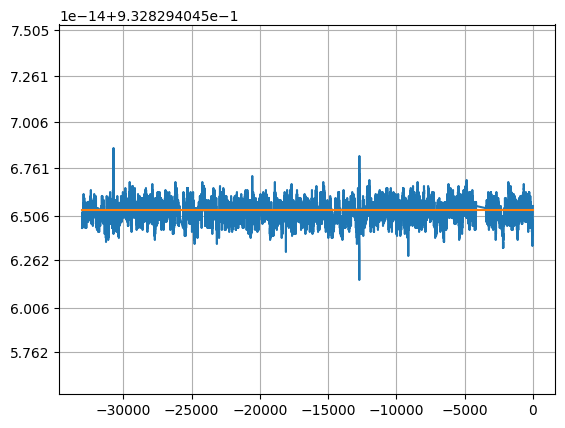

In [109]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

In [337]:
aom20251110b = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251110_1.mat"
moku20251110b = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251110_174341.csv"
data20251110b = files2datawCEOmix(moku20251110b, aom20251110b, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251110b)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251110bserv = data20251110b.copy()
data20251110bserv.extend([aom20251110b, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251110bserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 1
-4.122004747390747
case 1
0.0012149810791015625
matni:  7324
matnf:  10159
Done.
Start time:  2025-11-10 17:43:45.122005
End time:  2025-11-10 20:12:56.622999
2835  data points
Duration:  8688.708
~~~ Uncertainty:  5.3640448846361665e-17  ~~~
------Comb Teeth------
1376720.9998881616539078529449876779907995059102663
1376721.0
1284245.9998956748243289444102072703721182019011224
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -4.7665348248040713704819630275980080150788191392603
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998881616539078529449876779907995059102663
1376721.0
1284245.9998956748243289444102072703721182019011224
1284246.0
----------------------
oct exc fracs: 
0.4987649964714185 0.49382498235709243
0.30716302046577276 0.30963302752293576
Octupole Servo Error:  -0.008580449112588148
Quad Servo Errors:  [-0.01591737 -0.02473281 -0.02296608]


mpf('-6.5108454264570918719451011646193702037918386574035264')

In [111]:
aom20251110 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251110_1.mat"
moku20251110 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251110_104157.csv"
data20251110 = files2datawCEOmix(moku20251110, aom20251110, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251110)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251110serv = data20251110.copy()
data20251110serv.extend([aom20251110, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20251110serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0503268241882324
case 2
2.0599639415740967
matni:  0
matnf:  6687
Done.
Start time:  2025-11-10 10:54:53.734998
End time:  2025-11-10 17:10:22.278000
6687  data points
Duration:  20494.317600000002
~~~ Uncertainty:  3.492635574650274e-17  ~~~
------Comb Teeth------
1376720.9998883309933995836938715014966403463723725
1376721.0
1284245.999895832729361577288557393701503043593974
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -0.083863385528124335352137762865927896108201246186624
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998883309933995836938715014966403463723725
1376721.0
1284245.999895832729361577288557393701503043593974
1284246.0
----------------------
oct exc fracs: 
0.49917738558181274 0.4920729883338319
0.3119952138797487 0.3149117559078672
Octupole Servo Error:  -0.01234002507576014
Quad Servo Errors:  [-0.02997234 -0.02920553 -0.02396606]


mpf('-2.188295587900435945121078477551459994960185747855171')

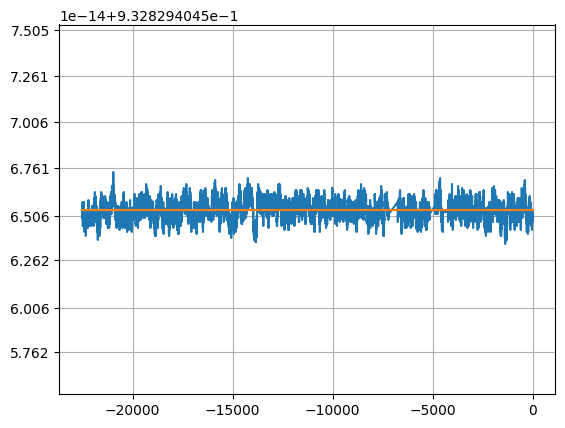

In [112]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

In [338]:
aom20251107b = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251107_2_a.mat"
moku20251107b = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251107_070754.csv"
data20251107b = files2datawCEOmix(moku20251107b, aom20251107b, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251107b)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251107bserv = data20251107b.copy()
data20251107bserv.extend([aom20251107b, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251107bserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.040069103240967
case 1
0.02410125732421875
matni:  0
matnf:  3077
Done.
Start time:  2025-11-07 13:19:14.766998
End time:  2025-11-07 16:01:11.697003
3077  data points
Duration:  9430.3896
~~~ Uncertainty:  5.148790092395568e-17  ~~~
------Comb Teeth------
1376720.9998996746762880254719424597676472210963245
1376721.0
1284245.9999064143507193181309165622176750537474948
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 7.7516443430234711991094065077836604149739308009308
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9998996746762880254719424597676472210963245
1376721.0
1284245.9999064143507193181309165622176750537474948
1284246.0
----------------------
oct exc fracs: 
0.5113784135240572 0.5110533159947984
0.3228218465539662 0.32200910273081923
Octupole Servo Error:  -0.0005647843152504125
Quad Servo Errors:  [0.01140176 0.00814462 0.00977521]


mpf('9.2594793629234251478788757711392770016765313863606673')

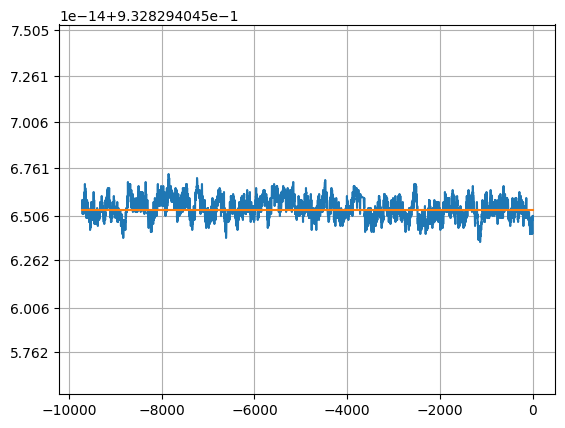

In [114]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

In [339]:
aom20251107 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251107_1.mat"
moku20251107 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251107_070754.csv"
data20251107 = files2datawCEOmix(moku20251107, aom20251107, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
data20251107 = snipData(data20251107, 3700)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251107)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251107serv = data20251107.copy()
data20251107serv.extend([aom20251107, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251107serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.052912473678589
case 1
0.018936872482299805
matni:  0
matnf:  3890
Done.
Start time:  2025-11-07 07:20:24.243004
End time:  2025-11-07 12:23:58.436002
3890  data points
Duration:  11922.072000000002
~~~ Uncertainty:  4.5792476813230174e-17  ~~~
case 2
-3.052912473678589
case 1
0.016865968704223633
matni:  0
matnf:  3700
------Comb Teeth------
1376720.9999004615386450560437997865192644812177666
1376721.0
1284245.9999071485517154250033043126368667077879938
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -7.3202477635949403473097610342278023278364583696562
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999004615386450560437997865192644812177666
1376721.0
1284245.9999071485517154250033043126368667077879938
1284246.0
----------------------
oct exc fracs: 
0.5025682616923492 0.4968910516355772
0.3181941065152744 0.32130305487969724
Octupole Servo Error:  -0.00986060431542216
Quad Servo Errors:  [-0.01

mpf('-9.5883998419491672355841075899583184601290308166597752')

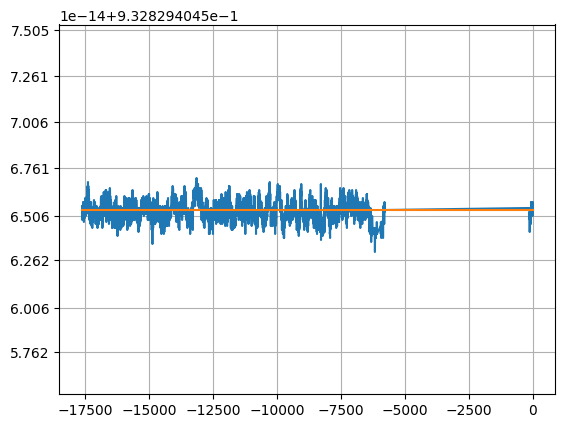

In [116]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

In [340]:
aom20251106 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251106_1_a.mat"
moku20251106 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251106_103015.csv"
data20251106 = files2datawCEOmix(moku20251106, aom20251106, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251106)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251106serv = data20251106.copy()
data20251106serv.extend([aom20251106, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251106serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.048344373703003
case 1
0.0021734237670898438
matni:  0
matnf:  2327
Done.
Start time:  2025-11-06 10:56:29.899001
End time:  2025-11-06 12:58:09.474002
2327  data points
Duration:  7131.789600000001
~~~ Uncertainty:  5.920668468921971e-17  ~~~
------Comb Teeth------
1376720.9999036361608537003705708922012351013373936
1376721.0
1284245.999910109878636072394726407390963646066241
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -2.8783011885280954423318033413927715172432579974418
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999036361608537003705708922012351013373936
1376721.0
1284245.999910109878636072394726407390963646066241
1284246.0
----------------------
oct exc fracs: 
0.4950558899398108 0.4926913155631986
0.3172828890799656 0.32158211521926056
Octupole Servo Error:  -0.004107291436198989
Quad Servo Errors:  [-0.01938618 -0.04306884 -0.01937386]


mpf('-6.2011662970918737926678831958684386760095029823166343')

In [118]:
aom20251105 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251105_1.mat"
moku20251105 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251105_102023.csv"
data20251105 = files2datawCEOmix(moku20251105, aom20251105, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251105)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251105serv = data20251105.copy()
data20251105serv.extend([aom20251105, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20251105serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.049487590789795
case 1
0.020435810089111328
matni:  0
matnf:  8956
Done.
Start time:  2025-11-05 10:32:02.209999
End time:  2025-11-05 18:33:41.692997
8956  data points
Duration:  27448.348800000003
~~~ Uncertainty:  3.0179489721328436e-17  ~~~
------Comb Teeth------
1376720.999906879346987270159448037318428200807982
1376721.0
1284245.999913135212144991157495329576337538363803
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -2.5787413386953228727800838023814306383875543374776
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.999906879346987270159448037318428200807982
1376721.0
1284245.999913135212144991157495329576337538363803
1284246.0
----------------------
oct exc fracs: 
0.4937465103294249 0.4977107761027359
0.31943048576214406 0.3174204355108878
Octupole Servo Error:  0.006885701841420974
Quad Servo Errors:  [0.02015767 0.02013429 0.02180663]


mpf('-0.64399404477346367426371749967794233220703534075065174')

In [341]:
aom20251104 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251104_1.mat"
moku20251104 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251104_092913.csv"
data20251104 = files2datawCEOmix(moku20251104, aom20251104, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251104)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251104serv = data20251104.copy()
data20251104serv.extend([aom20251104, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251104serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0397837162017822
case 1
0.014153242111206055
matni:  0
matnf:  10200
Done.
Start time:  2025-11-04 09:41:34.801002
End time:  2025-11-04 18:42:01.864002
10200  data points
Duration:  31260.960000000003
~~~ Uncertainty:  2.827931262193469e-17  ~~~
------Comb Teeth------
1376720.9999104271958090668792456513573319710763588
1376721.0
1284245.9999164447044281281472605202795443887160016
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 1.0276891227590569034509003264392416490800300747886
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999104271958090668792456513573319710763588
1376721.0
1284245.9999164447044281281472605202795443887160016
1284246.0
----------------------
oct exc fracs: 
0.5029414648494951 0.48789096970291207
0.31414844592607116 0.3190999117560545
Octupole Servo Error:  -0.026142919989984314
Quad Servo Errors:  [-0.04865452 -0.04959134 -0.04958002]


mpf('-2.059345582069694974286972238497077698702145345738996')

In [120]:
aom20251103 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251103_1.mat"
moku20251103 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251103_100635.csv"
data20251103 = files2datawCEOmix(moku20251103, aom20251103, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251103)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251103serv = data20251103.copy()
data20251103serv.extend([aom20251103, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20251103serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.053413152694702
case 1
0.004147052764892578
matni:  0
matnf:  8633
Done.
Start time:  2025-11-03 10:40:06.057998
End time:  2025-11-03 18:16:29.241999
8633  data points
Duration:  26458.418400000002
~~~ Uncertainty:  3.07388817601856e-17  ~~~
------Comb Teeth------
1376720.9999135502960143123730289368292355475538107
1376721.0
1284245.9999193580074837398722028039563614286369813
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: 2.3360071121719940192999069828830156044471824940155
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999135502960143123730289368292355475538107
1376721.0
1284245.9999193580074837398722028039563614286369813
1284246.0
----------------------
oct exc fracs: 
0.5 0.4862720111214087
0.3174814643188137 0.32170991658943465
Octupole Servo Error:  -0.0238468743029342
Quad Servo Errors:  [-0.04469296 -0.04236051 -0.04524187]


mpf('-0.35654380278527288876718846868026760090631732548445558')

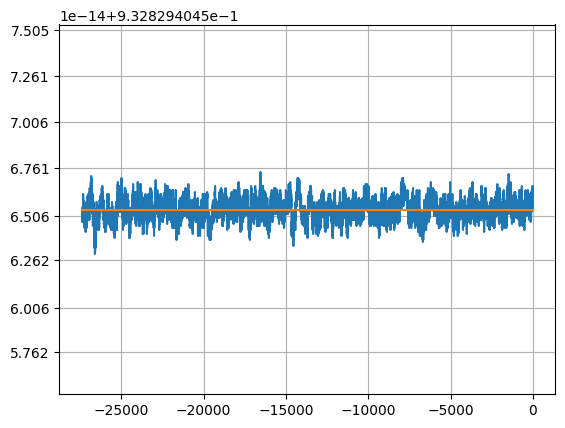

In [121]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

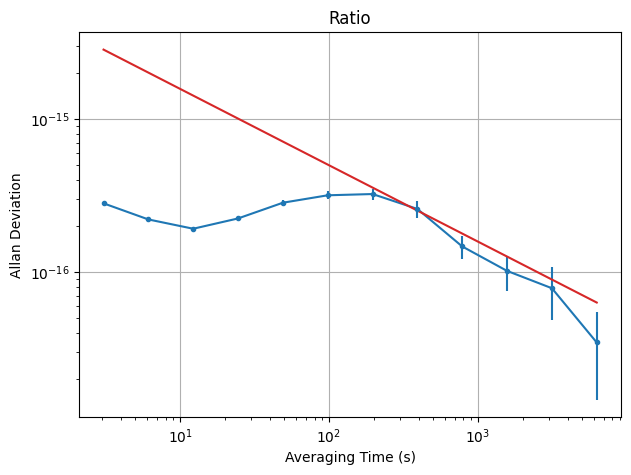

In [122]:
A = 0.5e-14
floatRs = np.array([float(pt) for pt in R])
rate = 1./tInt
taus,adev,adevErr,_ = al.adev(floatRs, rate, data_type="freq")
plt.figure(figsize=(7,5), dpi = 100)
plt.errorbar(taus, adev, yerr=adevErr, fmt=".", c="tab:blue")
plt.loglog(taus, adev, label="Ratio", c="tab:blue")
plt.loglog(taus, A/np.sqrt(taus), c="tab:red")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Allan Deviation")
plt.xlabel("Averaging Time (s)")
plt.title("Ratio")
#plt.ylim([1e-17, 3e-15])
#plt.xlim([2, 4e4])
plt.grid()
plt.show()

In [342]:
aom20251031 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251031_1.mat"
moku20251031 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251031_093418.csv"
data20251031 = files2datawCEOmix(moku20251031, aom20251031, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251031)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251031serv = data20251031.copy()
data20251031serv.extend([aom20251031, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251031serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.040844678878784
case 1
0.007445335388183594
matni:  0
matnf:  6186
Done.
Start time:  2025-10-31 09:46:56.284000
End time:  2025-10-31 15:11:46.079001
6186  data points
Duration:  18958.852800000004
~~~ Uncertainty:  3.6313154465338925e-17  ~~~
------Comb Teeth------
1376720.9999217151240115889584183412324613595418959
1376721.0
1284245.9999269745057621911083804569143917147620096
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -5.9077452579384260679102162729617566685624511729262
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999217151240115889584183412324613595418959
1376721.0
1284245.9999269745057621911083804569143917147620096
1284246.0
----------------------
oct exc fracs: 
0.49725141471301537 0.49288601455133385
0.3215844785772029 0.3238480194017785
Octupole Servo Error:  -0.007582552184652438
Quad Servo Errors:  [-0.02352099 -0.02268419 -0.02185595]


mpf('-8.0227025315320510609803737734428969469682966774991563')

In [124]:
aom20251030a = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251030_1.mat"
moku20251030a = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251030_101343.csv"
data20251030a = files2datawCEOmix(moku20251030a, aom20251030a, 1, -1, 19997931.185/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251030a)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251030aserv = data20251030a.copy()
data20251030aserv.extend([aom20251030a, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, Rs, ratio = ratioCalcwServoErr(data20251030aserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.040222644805908
case 2
2.324953556060791
matni:  0
matnf:  1510
Done.
Start time:  2025-10-30 10:24:30.339004
End time:  2025-10-30 11:51:23.546998
1510  data points
Duration:  4627.848000000001
~~~ Uncertainty:  7.349883599639168e-17  ~~~
------Comb Teeth------
1376720.9999247504557649440226222941549715494298928
1376721.0
1284245.9999298059411819692015808792628152945085767
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -4.9450670169837579978486840238897189362663942022466
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376720.9999247504557649440226222941549715494298928
1376721.0
1284245.9999298059411819692015808792628152945085767
1284246.0
----------------------
oct exc fracs: 
0.48807157057654077 0.5089463220675944
0.3333333333333333 0.3210735586481113
Octupole Servo Error:  0.03625948877383147
Quad Servo Errors:  [0.11304718 0.12295584 0.11948912]


mpf('6.6225810100020278683380744251833902504790806703358529')

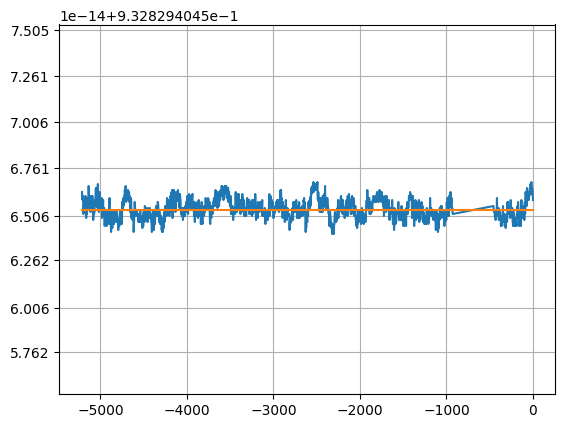

In [125]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

# End period after laser ratio lock

In [343]:
aom20251014a = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251014_1_d.mat"
moku20251014a = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251014_093507.csv"
data20251014a = files2data(moku20251014a, aom20251014a, 1, -1, 19997926/4+245000000)
#f933New = remBeatOuts(f933, 3)
#f871New = remBeatOuts(f871, 3)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251014a)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251014aserv = data20251014a.copy()
data20251014aserv.extend([aom20251014a, 1e-3, 52e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251014aserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.0586750507354736
case 1
0.007641315460205078
matni:  0
matnf:  11884
Done.
Start time:  2025-10-14 09:47:35.664998
End time:  2025-10-14 20:27:16.104004
11884  data points
Duration:  36422.08320000001
~~~ Uncertainty:  2.6199174848075676e-17  ~~~
------Comb Teeth------
1376721.0071121830561286502702566956686368167527579
1376721.0
1284246.0066344553009472480429951511328809495950895
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -3.3831411732981000141223524575792369927753607509877
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376721.0071121830561286502702566956686368167527579
1376721.0
1284246.0066344553009472480429951511328809495950895
1284246.0
----------------------
oct exc fracs: 
0.5037869224943197 0.49899015400151475
0.3257594883446941 0.32685348817638643
Octupole Servo Error:  -0.008331387287815182
Quad Servo Errors:  [-0.00771923 -0.01055769 -0.00689532]


mpf('-3.3046116400610271468731399576659782204672323225749552')

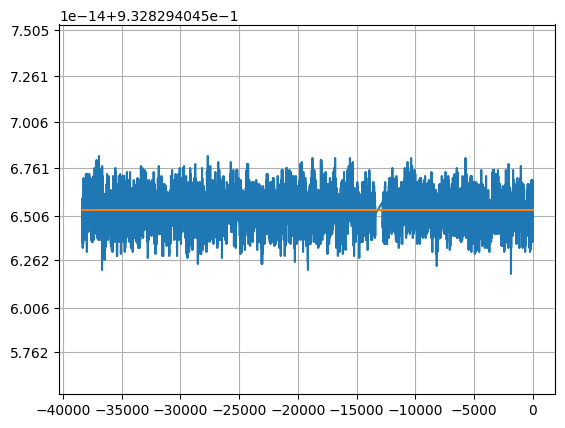

In [127]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

In [344]:
aom20251010b = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251010_1_e.mat"
moku20251010b = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251010_140724.csv"
data20251010b = files2data(moku20251010b, aom20251010b, 1, -1, 19997926.18/4+245000000)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251010b)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251010bserv = data20251010b.copy()
data20251010bserv.extend([aom20251010b, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251010bserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 1
-3.300997018814087
case 1
0.017180442810058594
matni:  5461
matnf:  10112
Done.
Start time:  2025-10-10 14:07:27.300997
End time:  2025-10-10 18:23:34.945997
4651  data points
Duration:  14254.384800000002
~~~ Uncertainty:  4.187894813836505e-17  ~~~
------Comb Teeth------
1376721.0068747523240779644966922303882219426565847
1376721.0
1284246.0064129728683187633119906783712047392323829
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -10.442021890681855238524140063935089141450183401563
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376721.0068747523240779644966922303882219426565847
1376721.0
1284246.0064129728683187633119906783712047392323829
1284246.0
----------------------
oct exc fracs: 
0.502258064516129 0.49946236559139784
0.32623655913978494 0.32505376344086023
Octupole Servo Error:  -0.004855759106604296
Quad Servo Errors:  [0.01402619 0.01185856 0.00215392]


mpf('-8.3280632933994952429408121917244316627608826933652878')

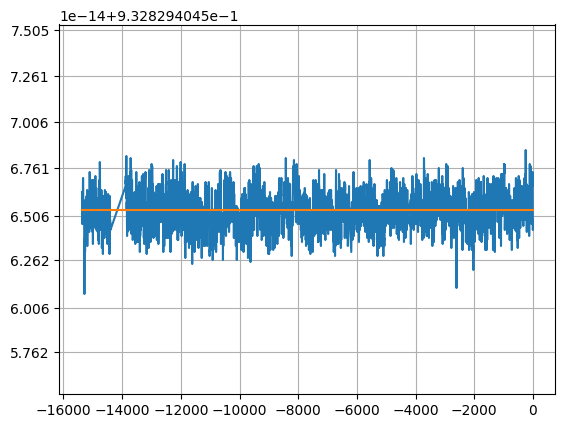

In [129]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

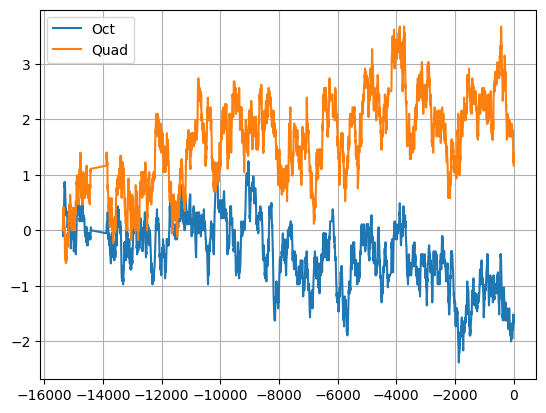

In [130]:
fe2aom=[]
for ii in range(int(np.size(fe2aoms)/3)):
    fe2aom.append((fe2aoms[0][ii]+fe2aoms[1][ii]+fe2aoms[2][ii])/3)
plt.plot(taoms-taoms[-1], fe3aom-fe3aom[0],label="Oct")
plt.plot(taoms-taoms[-1], fe2aom-fe2aom[0],label="Quad")
plt.legend()
plt.grid()

In [345]:
aom20251010a = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251010_1_b.mat"
moku20251010a = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251010_090531.csv"
data20251010a = files2data(moku20251010a, aom20251010a, 1, -1, 19997926.18/4+245000000)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251010a)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251010aserv = data20251010a.copy()
data20251010aserv.extend([aom20251010a, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251010aserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.060758590698242
case 2
0.6311030387878418
matni:  0
matnf:  5161
Done.
Start time:  2025-10-10 09:14:25.213995
End time:  2025-10-10 13:51:48.707999
5161  data points
Duration:  15817.432800000002
~~~ Uncertainty:  3.97559380615505e-17  ~~~
------Comb Teeth------
1376721.0068753680403924038064222379156336727946449
1376721.0
1284246.0064135472485771220214650132319397219354343
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -1.5171903908881625652549459578395748912860279553806
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376721.0068753680403924038064222379156336727946449
1376721.0
1284246.0064135472485771220214650132319397219354343
1284246.0
----------------------
oct exc fracs: 
0.499515503875969 0.4947674418604651
0.32819767441860465 0.32655038759689925
Octupole Servo Error:  -0.008246938694448258
Quad Servo Errors:  [0.0184761  0.01652042 0.018443  ]


mpf('2.3549113472918135860448660935013964776590494096920369')

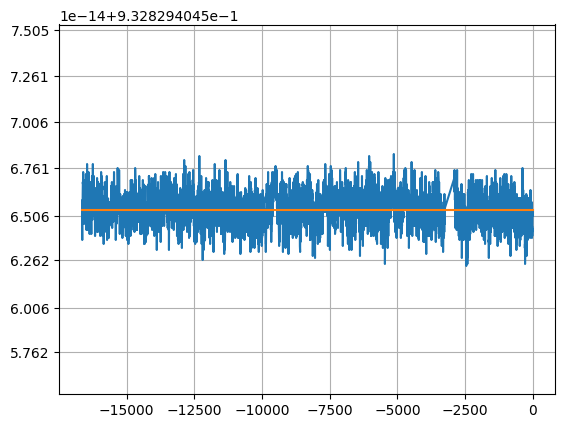

In [132]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

In [346]:
aom20251009 = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251009_1.mat"
moku20251009 = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251009_075038.csv"
data20251009 = files2data(moku20251009, aom20251009, 1, -1, 19997926.18/4+245000000)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251009)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


data20251009serv = data20251009.copy()
data20251009serv.extend([aom20251009, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251009serv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.045332431793213
case 1
0.022062301635742188
matni:  0
matnf:  13140
Done.
Start time:  2025-10-09 08:12:56.807005
End time:  2025-10-09 20:02:51.440001
13140  data points
Duration:  40271.47200000001
~~~ Uncertainty:  2.491559439082622e-17  ~~~
------Comb Teeth------
1376721.0068780318829983450360786259537122304410273
1376721.0
1284246.0064160321346816287862484158296004053282305
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -2.9277547978419310263709431747023369418912607569144
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------Comb Teeth------
1376721.0068780318829983450360786259537122304410273
1376721.0
1284246.0064160321346816287862484158296004053282305
1284246.0
----------------------
oct exc fracs: 
0.49980972676763835 0.4947865134332902
0.33096126036989115 0.3323312276428952
Octupole Servo Error:  -0.00872483765249029
Quad Servo Errors:  [-0.01259426 -0.01375118 -0.01411048]


mpf('-3.5280536900291690170436571634809138802701125498137159')

In [134]:
A = 0.5e-14
#print("total duration is: ", np.sum(Ts))
print("error bar is:", A/np.sqrt( 38659.387200000005))

error bar is: 2.54297752295022e-17


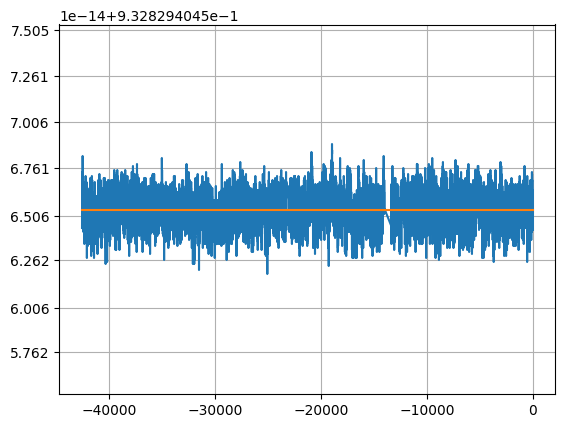

In [135]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

In [136]:
newRatio, mask = maskedRatio(False, True, 10, 0.02, fe3aom, np.array(R))
print(np.size(newRatio))
1e17*(mp.fsum(newRatio)/np.size(newRatio)-R_Lange)/R_Lange

positive segments:  []
negative segments:  [(2, 20), (34, 56), (68, 80), (72, 82), (111, 130), (138, 157), (170, 189), (181, 191), (199, 210), (208, 218), (233, 259), (323, 333), (326, 340), (333, 344), (356, 366), (360, 378), (405, 418), (422, 442), (436, 446), (479, 494), (486, 496), (488, 498), (515, 527), (520, 535), (573, 590), (601, 621), (644, 658), (659, 676), (707, 722), (714, 724), (725, 740), (768, 798), (833, 853), (845, 865), (881, 894), (921, 934), (946, 965), (983, 1001), (1025, 1037), (1032, 1051), (1054, 1064), (1072, 1090), (1083, 1096), (1089, 1103), (1126, 1148), (1154, 1164), (1162, 1180), (1179, 1195), (1212, 1222), (1247, 1260), (1252, 1262), (1254, 1266), (1270, 1302), (1329, 1339), (1351, 1366), (1395, 1411), (1415, 1433), (1434, 1446), (1438, 1448), (1446, 1461), (1455, 1465), (1489, 1499), (1496, 1510), (1536, 1554), (1558, 1568), (1561, 1576), (1622, 1635), (1637, 1653), (1673, 1692), (1701, 1718), (1716, 1726), (1719, 1729), (1722, 1732), (1725, 1735), (172

mpf('10.25453170667986472174373314672678491573427239461548')

In [137]:
findHighSlope(fe3aom, window=30, slope_threshold=0.02, direction='negative')

[(224, 257),
 (233, 263),
 (404, 438),
 (415, 446),
 (424, 454),
 (644, 676),
 (707, 740),
 (758, 803),
 (831, 868),
 (938, 972),
 (944, 974),
 (948, 978),
 (1026, 1059),
 (1070, 1103),
 (1075, 1105),
 (1077, 1107),
 (1163, 1193),
 (1255, 1285),
 (1258, 1289),
 (1261, 1308),
 (1435, 1466),
 (1704, 1737),
 (1839, 1874),
 (1864, 1896),
 (2064, 2096),
 (2068, 2098),
 (2427, 2458),
 (2445, 2475),
 (2448, 2479),
 (2590, 2621),
 (2789, 2820),
 (2931, 2962),
 (2935, 2966),
 (2986, 3028),
 (3095, 3126),
 (3328, 3358),
 (3331, 3367),
 (3339, 3369),
 (3341, 3371),
 (3348, 3379),
 (3479, 3513),
 (3609, 3641),
 (3645, 3679),
 (3651, 3691),
 (3837, 3868),
 (3938, 3969),
 (4285, 4316),
 (4417, 4447),
 (4420, 4452),
 (4501, 4532),
 (4585, 4616),
 (4588, 4619),
 (4700, 4730),
 (4702, 4746),
 (4718, 4748),
 (5039, 5069),
 (5076, 5109),
 (5317, 5347),
 (5321, 5363),
 (5505, 5540),
 (5600, 5630),
 (5605, 5652),
 (5768, 5799),
 (5839, 5878),
 (5964, 5994),
 (5981, 6012),
 (5988, 6021),
 (6050, 6097),
 (60

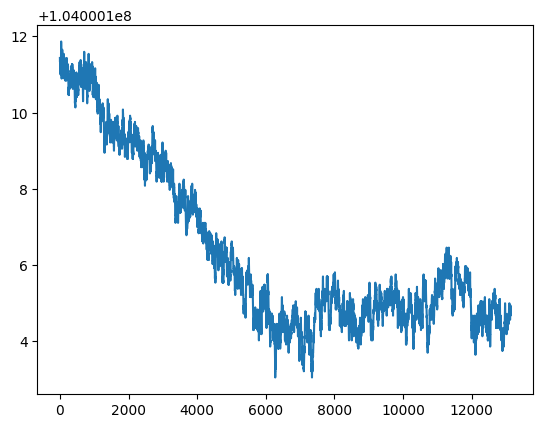

In [138]:
plt.plot(fe3aom)

(3000.0, 4000.0)

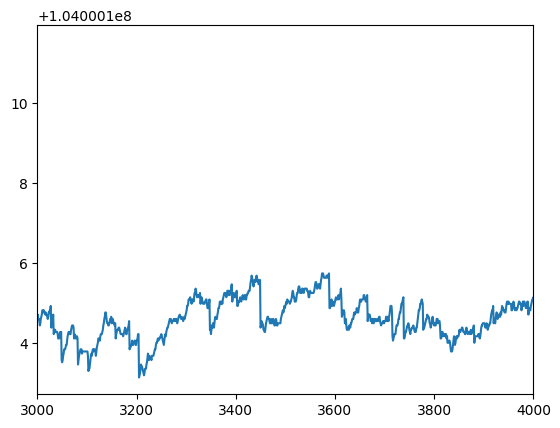

In [139]:
fe3aomMasked=fe3aom[mask]
plt.plot(fe3aomMasked)
plt.xlim([3000,4000])

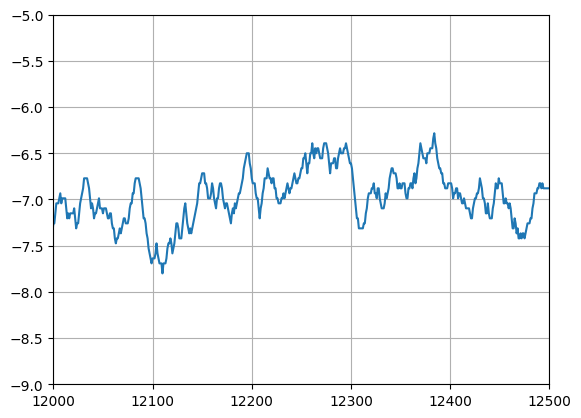

In [140]:
plt.plot(fe3aom-fe3aom[0])
plt.ylim([-9,-5])

plt.xlim([12000,12500])
plt.grid()
plt.show()

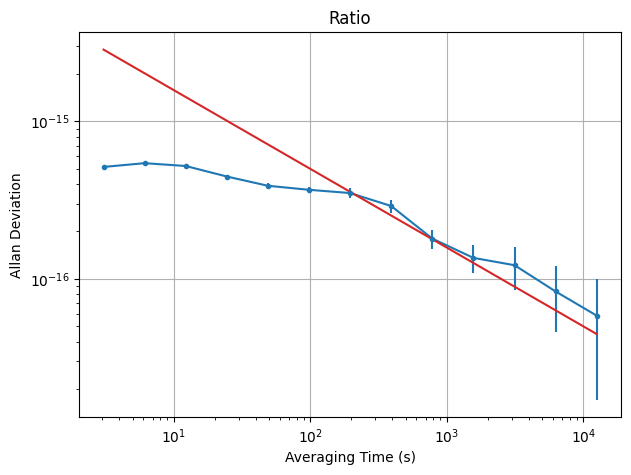

In [141]:
A = 0.5e-14
floatRs = np.array([float(pt) for pt in R])
rate = 1./tInt
taus,adev,adevErr,_ = al.adev(floatRs, rate, data_type="freq")
plt.figure(figsize=(7,5), dpi = 100)
plt.errorbar(taus, adev, yerr=adevErr, fmt=".", c="tab:blue")
plt.loglog(taus, adev, label="Ratio", c="tab:blue")
plt.loglog(taus, A/np.sqrt(taus), c="tab:red")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Allan Deviation")
plt.xlabel("Averaging Time (s)")
plt.title("Ratio")
#plt.ylim([1e-17, 3e-15])
#plt.xlim([2, 4e4])
plt.grid()
plt.show()

In [347]:
aom20251008a = r"C:\Users\sanner_lab2\Documents\Data\Clock Runs\aomfrequs-20251008_2.mat"
moku20251008a = r"C:\Users\sanner_lab2\Documents\Data\Clock Laser Noise Comparison\ThreeCorneredHat\MokuPhasemeterData_20251008_091112.csv"
data20251008a = files2data(moku20251008a, aom20251008a, 1, -1, 19997926.18/4+245000000)
taoms, Rs, ratio, fe3aom, fe2aoms = ratioCalc(data20251008a)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Ratio Offset:", 1e17*(ratioVal-R_Lange)/R_Lange)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(taoms[-1]-taoms[0])

data20251008aserv = data20251008a.copy()
data20251008aserv.extend([aom20251008a, 1e-3, 50e-3, 26.2e-3, 150e-3])
taoms, fe2aoms, fe3aom, RwOutServoCorrects, Rs, ratio = ratioCalcwServoErr(data20251008aserv)
ratioVal = (mp.fsum(Rs[0])/np.size(Rs[0])+mp.fsum(Rs[1])/np.size(Rs[1])+mp.fsum(Rs[2])/np.size(Rs[2]))/3
1e17*(ratioVal-R_Lange)/R_Lange

Trimming.....
case 2
-3.042877435684204
case 2
1.6590237617492676
matni:  0
matnf:  6658
Done.
Start time:  2025-10-08 15:17:45.006997
End time:  2025-10-08 21:11:10.329999
6658  data points
Duration:  20405.438400000003
~~~ Uncertainty:  3.500233680600755e-17  ~~~
------Comb Teeth------
1376721.0068802474169895871109440912447004530014158
1376721.0
1284246.0064180988471076935565350529231166018303733
1284246.0
----------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ratio Offset: -2.5881135559232418860670011782521868282719880694165
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
21205.323001861572
------Comb Teeth------
1376721.0068802474169895871109440912447004530014158
1376721.0
1284246.0064180988471076935565350529231166018303733
1284246.0
----------------------
oct exc fracs: 
0.5022532672374944 0.49624455460417605
0.3275499474237645 0.3275499474237645
Octupole Servo Error:  -0.01043640645657525
Quad Servo Errors:  [ 0.00225839  0.         -0.00150432]


mpf('-0.92629803832594237041757265875849945757997570544318361')

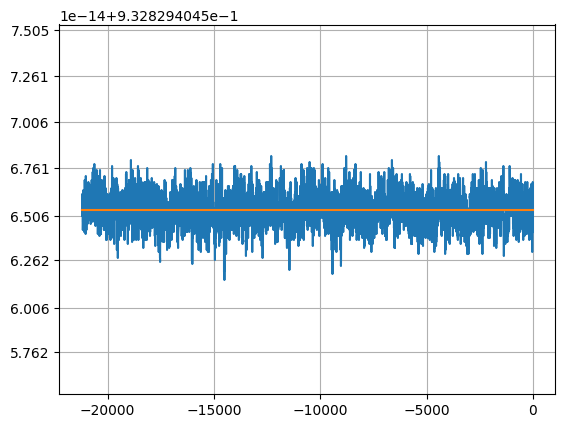

In [143]:
R =[]
for ii in range(int(np.size(Rs)/3)):
    R.append((Rs[0,ii]+Rs[1,ii]+Rs[2,ii])/3)
lim = 1e-14
plt.plot(taoms-taoms[-1], R)
plt.plot([taoms[0]-taoms[-1], 0], [R_Lange, R_Lange])
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.grid()
#plt.xlim([-1000,-800])

In [144]:
A = 0.5e-14
floatRs = np.array([float(pt) for pt in R])
rate = 1./tInt
taus,adev,adevErr,_ = al.adev(floatRs, rate, data_type="freq")

In [145]:
A = 0.5e-14
#print("total duration is: ", np.sum(Ts))
print("error bar is:", A/np.sqrt(21733.999))

error bar is: 3.391565297897859e-17


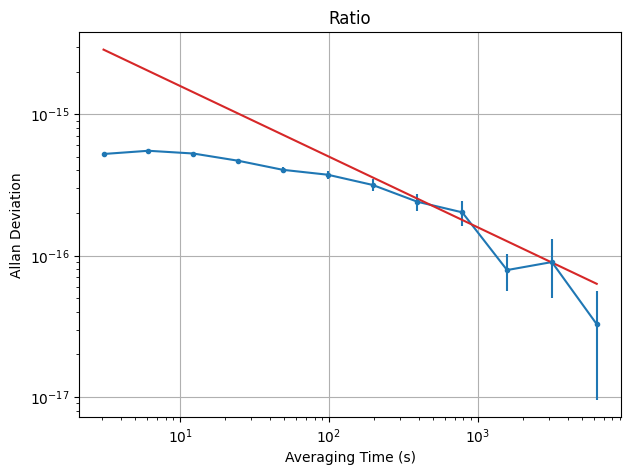

In [146]:
plt.figure(figsize=(7,5), dpi = 100)
plt.errorbar(taus, adev, yerr=adevErr, fmt=".", c="tab:blue")
plt.loglog(taus, adev, label="Ratio", c="tab:blue")
plt.loglog(taus, A/np.sqrt(taus), c="tab:red")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Allan Deviation")
plt.xlabel("Averaging Time (s)")
plt.title("Ratio")
#plt.ylim([1e-17, 3e-15])
#plt.xlim([2, 4e4])
plt.grid()
plt.show()

In [147]:
sets = []
sets.append(data20251014aserv)
sets.append(data20251009serv)
sets.append(data20251010bserv)
sets.append(data20251010aserv)
sets.append(data20251008aserv)


In [148]:
ts, Ratio, discRs, Ts, t0s, Ns = fullRatiowServoErr(sets, 5)
Rs = np.zeros(np.shape(Ratio)[1])
for ii in range(np.shape(Ratio)[1]):
    Rs[ii] = (Ratio[0][ii]+Ratio[1][ii]+Ratio[2][ii])/3

----- 1 -----
------Comb Teeth------
1376721.0071121830561286502702566956686368167527579
1376721.0
1284246.0066344553009472480429951511328809495950895
1284246.0
----------------------
oct exc fracs: 
0.5037869224943197 0.49899015400151475
0.3257594883446941 0.32685348817638643
Octupole Servo Error:  -0.008331387287815182
Quad Servo Errors:  [-0.00771923 -0.01055769 -0.00689532]
----- 2 -----
------Comb Teeth------
1376721.0068780318829983450360786259537122304410273
1376721.0
1284246.0064160321346816287862484158296004053282305
1284246.0
----------------------
oct exc fracs: 
0.49980972676763835 0.4947865134332902
0.33096126036989115 0.3323312276428952
Octupole Servo Error:  -0.00872483765249029
Quad Servo Errors:  [-0.01259426 -0.01375118 -0.01411048]
----- 3 -----
------Comb Teeth------
1376721.0068747523240779644966922303882219426565847
1376721.0
1284246.0064129728683187633119906783712047392323829
1284246.0
----------------------
oct exc fracs: 
0.502258064516129 0.49946236559139784
0

In [149]:
1e17*(mp.fsum(Rs)/np.size(Rs)-R_Lange)/R_Lange

mpf('-2.8539975407926921385852603443795707188262332257874455')

In [150]:
lim = 1e-14/3
RCuts = remOuts(Rs, lim)
1e17*(mp.fsum(RCuts)/np.size(RCuts)-R_Lange)/R_Lange

mpf('-2.8451058491427967863679813308369293220033596985999661')

In [151]:
A = 0.6e-14
print("total duration is: ", np.sum(Ns)*tInt)
print("error bar is:", A/np.sqrt(np.sum(Ns)*tInt))
1e17*(mp.fsum(Rs)/np.size(Rs)-R_Lange)/R_Lange

total duration is:  127170.81120000001
error bar is: 1.6825095175099834e-17


mpf('-2.8451058491427967863679813308369293220033596985999661')

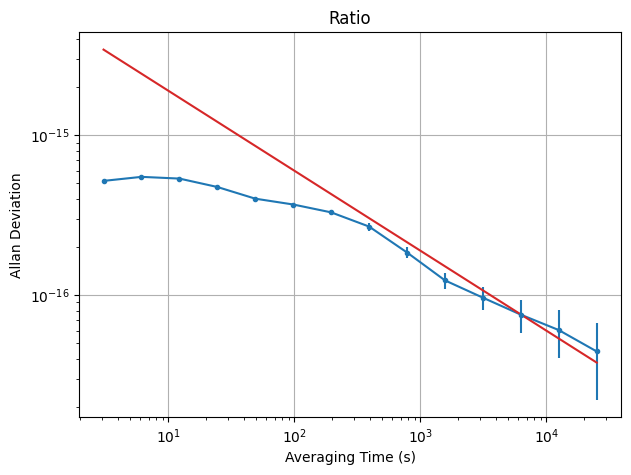

In [152]:
floatRs = np.array([float(pt) for pt in Rs])
rate = 1./tInt
taus,adev,adevErr,_ = al.adev(Rs, rate, data_type="freq")
plt.figure(figsize=(7,5), dpi = 100)

plt.errorbar(taus, adev, yerr=adevErr, fmt=".", c="tab:blue")
plt.loglog(taus, adev, label="Ratio", c="tab:blue")
plt.loglog(taus, A/np.sqrt(taus), c="tab:red")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Allan Deviation")
plt.xlabel("Averaging Time (s)")
plt.title("Ratio")
#plt.ylim([1e-17, 3e-15])
#plt.xlim([2, 4e4])
plt.grid()
plt.show()

# Allan Dev for period after ratio lock

In [380]:
sets = []
sets.append(data20260212bserv)
sets.append(data20260212aserv)
sets.append(data20260211serv)
sets.append(data20260210serv)
#sets.append(data20260202aserv)
sets.append(data20260130serv)
sets.append(data20260128serv)
sets.append(data20260127bserv)
sets.append(data20260127aserv)
sets.append(data20260126serv)
sets.append(data20260123bserv)
sets.append(data20260123aserv)
sets.append(data20260122serv)
sets.append(data20260121serv)
sets.append(data20251219serv)
sets.append(data20251217serv)
sets.append(data20251216bserv)
sets.append(data20251216aserv)
sets.append(data20251215serv)
sets.append(data20251212serv)
sets.append(data20251211serv)
sets.append(data20251210serv)
sets.append(data20251209serv)
sets.append(data20251208serv)
sets.append(data20251205serv)
sets.append(data20251202serv)
sets.append(data20251126serv)
sets.append(data20251124bserv)
sets.append(data20251124aserv)
sets.append(data20251121serv)
sets.append(data20251120serv)
sets.append(data20251119serv)
sets.append(data20251117serv)
sets.append(data20251114bserv)
sets.append(data20251114serv)
sets.append(data20251113serv)
sets.append(data20251112serv)
sets.append(data20251111serv)
sets.append(data20251110bserv)
sets.append(data20251110serv)
sets.append(data20251107bserv)
sets.append(data20251107serv)
sets.append(data20251106serv)
sets.append(data20251105serv)
sets.append(data20251104serv)
sets.append(data20251103serv)
sets.append(data20251031serv)
sets.append(data20251030aserv)

In [381]:
ts, fe3s, fe2s, RatiowOutServoCorrect, Ratio, discRs, Ts, t0s, Ns = fullRatiowServoErr(sets, 47)
Rs = []
for ii in range(np.shape(Ratio)[1]):
    Rs.append(mp.fsum([Ratio[0][ii]+Ratio[1][ii]+Ratio[2][ii]])/3)

Rpts = []
for ii in range(np.shape(discRs)[1]):
    Rpts.append(mp.fsum([discRs[0][ii],discRs[1][ii],discRs[2][ii]])/3)

----- 1 -----
------Comb Teeth------
1376720.9998538321967136364923010597770334261983737
1376721.0
1284245.9998636512886832214526764143221569816283118
1284246.0
----------------------
oct exc fracs: 
0.5009048603929679 0.5010341261633919
0.3218717683557394 0.3216132368148914
Octupole Servo Error:  0.00022451730439828377
Quad Servo Errors:  [0.         0.00259056 0.0012946 ]
----- 2 -----
------Comb Teeth------
1376720.9998538971295696151987152348454097881807876
1376721.0
1284245.9998637118973711834060161228111833730873312
1284246.0
----------------------
oct exc fracs: 
0.4986880944571991 0.5049196457855034
0.3237126926861266 0.3219088225647753
Octupole Servo Error:  0.01082347708985314
Quad Servo Errors:  [0.02465377 0.01807779 0.0246305 ]
----- 3 -----
------Comb Teeth------
1376720.999854289971535447584384633956328463105358
1376721.0
1284245.9998640781638012618796927322676040744291494
1284246.0
----------------------
oct exc fracs: 
0.5019825535289453 0.5001982553528945
0.3168120539

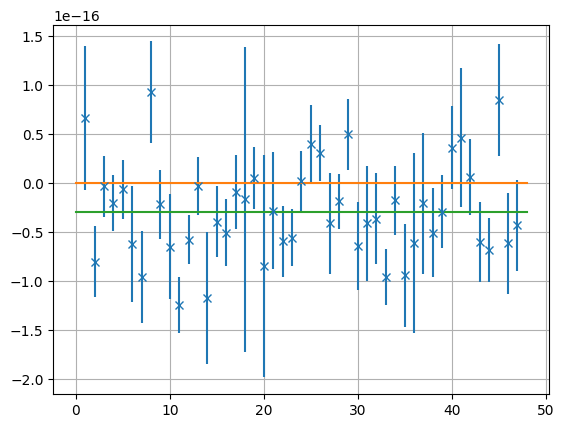

In [382]:
errs = np.zeros(np.size(Ns))
for ii in range(np.size(Ns)):
    errs[ii] = 0.5e-14/np.sqrt(Ns[ii]*tInt)

pts =np.flip(np.linspace(1,np.size(Rpts),np.size(Rpts)))

plt.errorbar(pts, (np.array(Rpts)-R_Lange)/R_Lange, yerr=errs, fmt = "x")
plt.plot([0,1+np.size(Rpts)], [0,0])
plt.plot([0,1+np.size(Rpts)], [(mp.fsum(Rs)/np.size(Rs)-R_Lange)/R_Lange,(mp.fsum(Rs)/np.size(Rs)-R_Lange)/R_Lange])

plt.grid()
plt.show()

In [383]:
1e17*(mp.fsum(Rs)/np.size(Rs)-R_Lange)/R_Lange

mpf('-3.0064459062124078938571667399904756709654456030142898')

In [384]:
lim = 1e-14/3
RCuts = remOuts(Rs, lim)
1e17*(mp.fsum(RCuts)/np.size(RCuts)-R_Lange)/R_Lange

mpf('-3.016555729843653199304998346191519391015308753289745')

In [385]:
A = 0.5e-14
print("total duration is: ", np.sum(Ns)*tInt)
print("error bar is:", A/np.sqrt(np.sum(Ns)*tInt))
1e17*(mp.fsum(Rs)/np.size(Rs)-R_Lange)/R_Lange

total duration is:  779887.3968000001
error bar is: 5.6617938624649554e-18


mpf('-3.016555729843653199304998346191519391015308753289745')

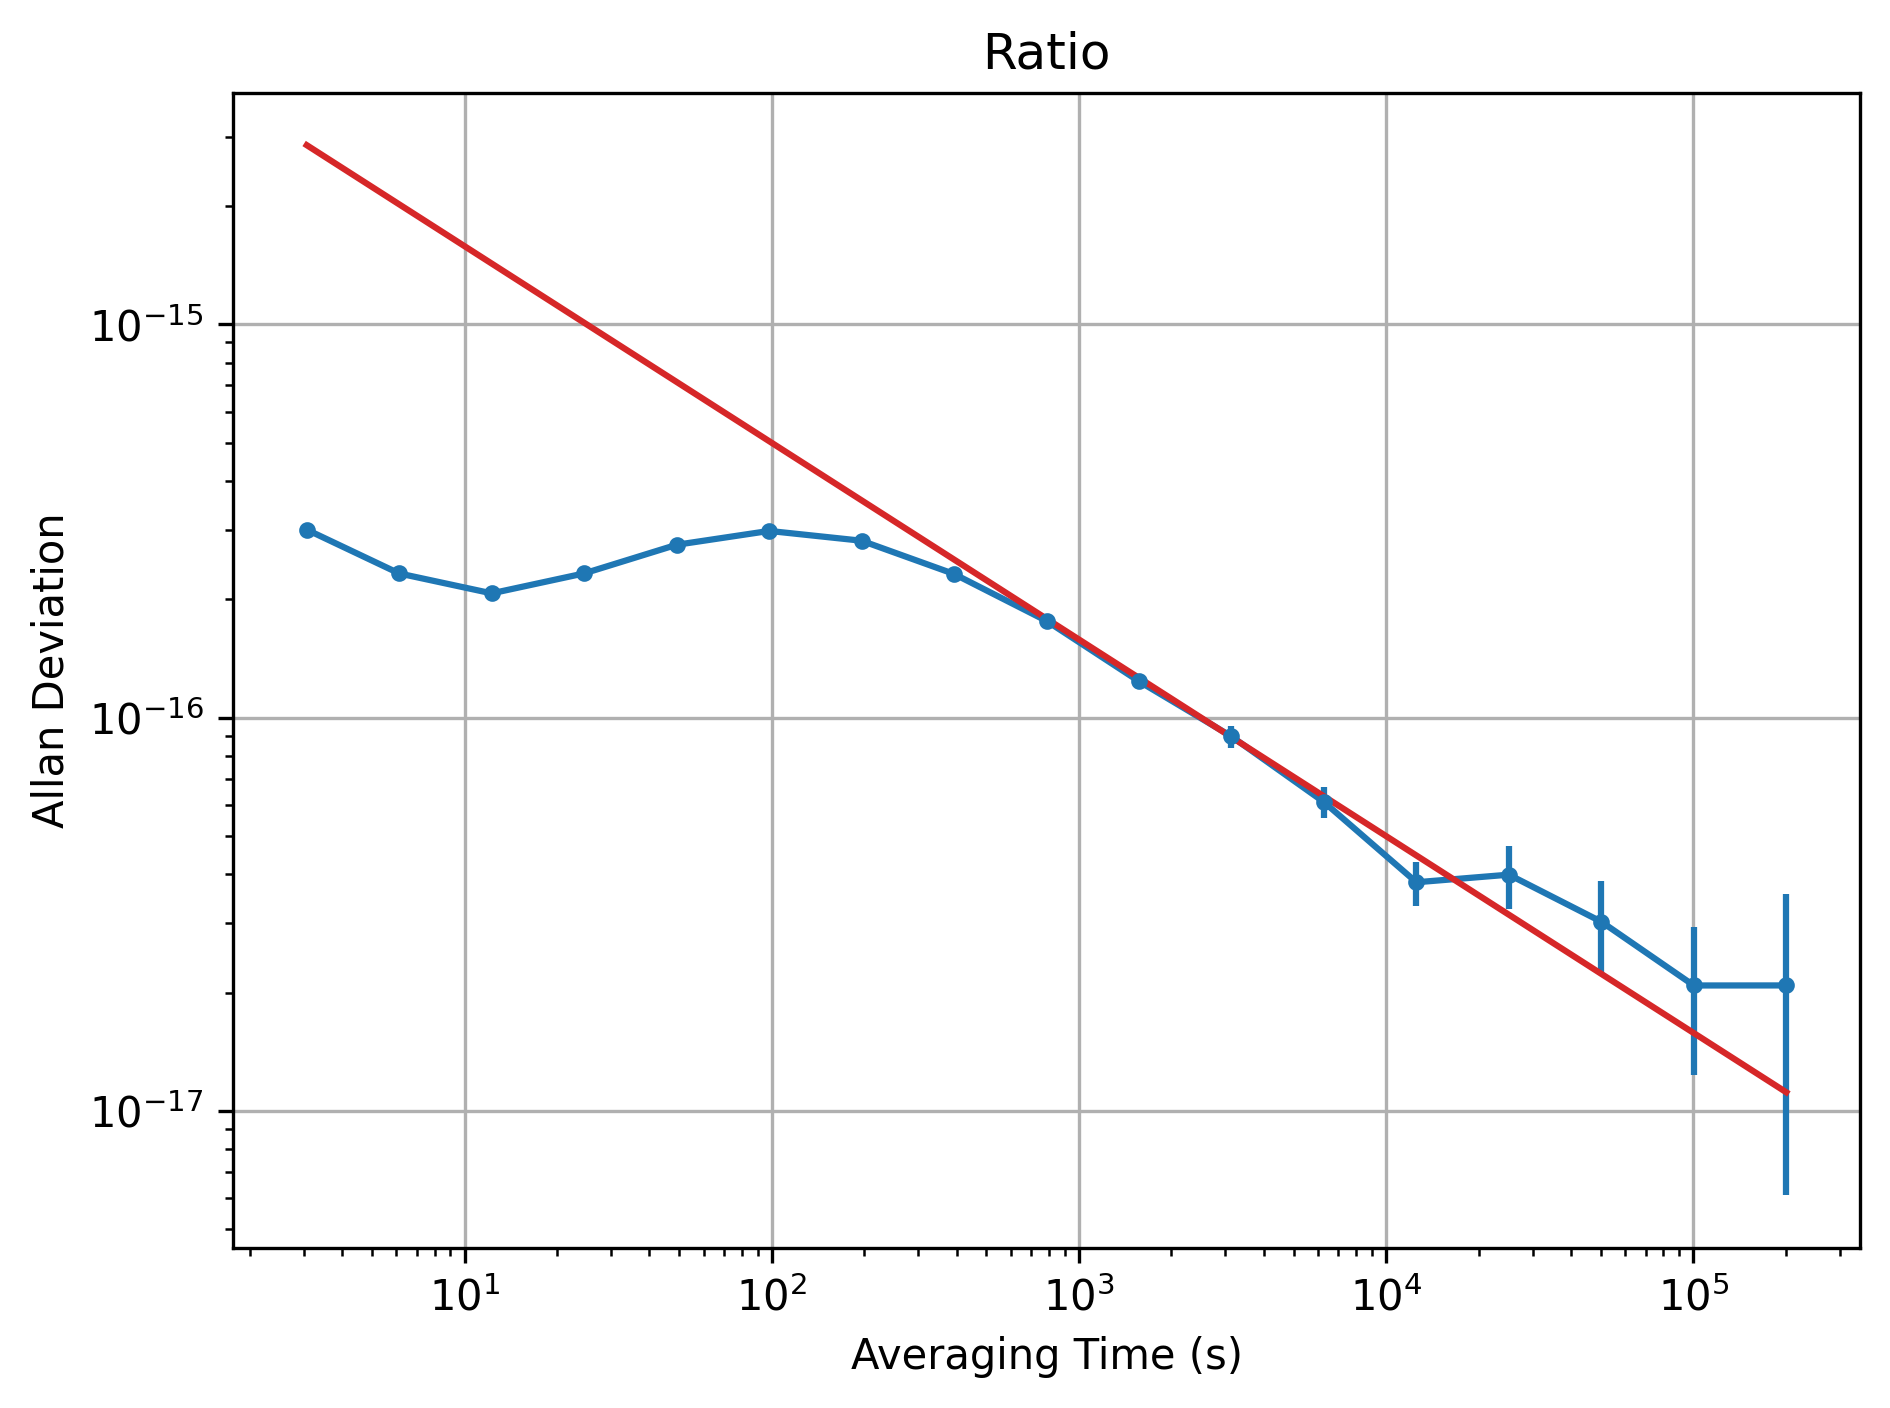

In [386]:
floatRs = np.array([float(pt) for pt in Rs])
rate = 1./tInt
taus,adev,adevErr,_ = al.adev(floatRs, rate, data_type="freq")
plt.figure(figsize=(7,5), dpi = 300)

plt.errorbar(taus, adev, yerr=adevErr, fmt=".", c="tab:blue")
plt.loglog(taus, adev, label="Ratio", c="tab:blue")
plt.loglog(taus, A/np.sqrt(taus), c="tab:red")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Allan Deviation")
plt.xlabel("Averaging Time (s)")
plt.title("Ratio")
#plt.ylim([1e-17, 3e-15])
#plt.xlim([2, 4e4])
plt.grid()
#plt.savefig("ratioAllanDev20251216.pdf")
plt.show()

In [160]:
chi2 = 0
avg = mp.fsum(Rs)/np.size(Rs)
for ii in range(np.size(Rpts)):
    chi2 += (Rpts[ii]-avg)**2/errs[ii]**2
chi2 = chi2/np.size(Rpts)
chi2

mpf('1.1620777275736045341754273339773386543955382355605774')

In [161]:
np.size(Rpts)

44

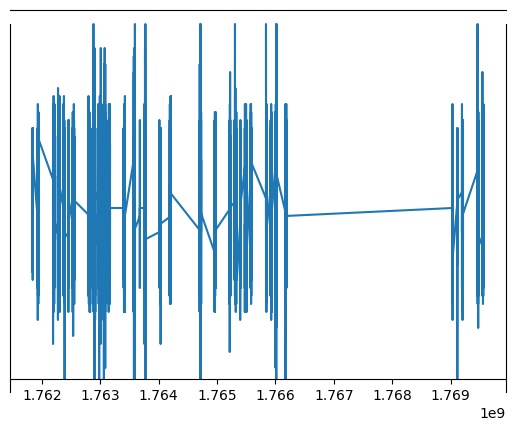

In [254]:
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.plot(ts, Rs)

In [291]:
Rstr0 = [str(x) for x in Ratio[0]]
Rstr1 = [str(x) for x in Ratio[1]]
Rstr2 = [str(x) for x in Ratio[2]]

RnoCorr0 = [str(x) for x in RatiowOutServoCorrect[0]]
RnoCorr1 = [str(x) for x in RatiowOutServoCorrect[1]]
RnoCorr2 = [str(x) for x in RatiowOutServoCorrect[2]]

In [292]:
RnoCorr0

['0.93282940453096695230520516751846975713370156532255',
 '0.93282940453096749920952678356827264587694938968572',
 '0.93282940453096681400744040035398286343201120527646',
 '0.93282940453096662817010566781899036506612109726163',
 '0.93282940453096681913454087979251074783987010175316',
 '0.93282940453096683990770909229130362777231478916815',
 '0.93282940453096684883350557282138571874518986949',
 '0.93282940453096745678960016088814175968211688938976',
 '0.93282940453096683905776171486573144084003350067912',
 '0.93282940453096687440929499290749167975325595988992',
 '0.93282940453096751893123589252124835480123064937974',
 '0.93282940453096678173071398846386608945671282689255',
 '0.93282940453096697196394029688796048842488263724529',
 '0.93282940453096614257506852798751736726239679747228',
 '0.93282940453096623862921407231343227530900057294916',
 '0.93282940453096574678615159226694044196636668303302',
 '0.93282940453096592378526078654067664338691624872356',
 '0.932829404530965494833500532564

In [293]:
combined_array = np.column_stack((ts, fe3s, fe2s[0], fe2s[1], fe2s[2], Rstr0, Rstr1, Rstr2, RnoCorr0, RnoCorr1, RnoCorr2))
np.savetxt('fullfreqData20260127.txt', combined_array, delimiter = ',', fmt="%s")

In [247]:
Rstr = [str(x) for x in Rs]
combined_array = np.column_stack((ts, Rstr))

In [248]:
combined_array

array([['1769555835.5579987',
        '0.93282940453096576401119937492146073449433100342008'],
       ['1769555838.6270025',
        '0.93282940453096631091552099096975686367435629441489'],
       ['1769555841.6940045',
        '0.93282940453096554666304185257548341321391780648662'],
       ...,
       ['1761846677.4180026',
        '0.9328294045309663925213340801528601440258845443385'],
       ['1761846680.483003',
        '0.9328294045309662041724251345337327789942978094006'],
       ['1761846683.5469975',
        '0.93282940453096587135343633626777737667279206502936']],
      dtype='<U52')

In [252]:
np.savetxt('freqData20260127.txt', combined_array, delimiter = ',', fmt="%s")

In [203]:
combined_array

array([[1769555835.5579987,
        mpf('0.93282940453096576401119937492146073449433100342007545')],
       [1769555838.6270025,
        mpf('0.93282940453096631091552099096975686367435629441489386')],
       [1769555841.6940045,
        mpf('0.9328294045309655466630418525754834132139178064866245')],
       ...,
       [1761846677.4180026,
        mpf('0.93282940453096639252133408015286014402588454433849648')],
       [1761846680.483003,
        mpf('0.93282940453096620417242513453373277899429780940059507')],
       [1761846683.5469975,
        mpf('0.93282940453096587135343633626777737667279206502936269')]],
      dtype=object)

In [294]:
data = np.loadtxt('fullfreqData20260127.txt', delimiter=',', dtype=str)

In [307]:
ts = data[:,0].astype(float)
fe3s = data[:,1].astype(float)
fe2s = np.array([data[:,2], data[:,3], data[:,4]], dtype=float)
Rpts = np.array([data[:,5], data[:,6], data[:,7]])
R = np.array([[mp.mpf(x) for x in row] for row in Rpts])
RnoCorrpts = np.array([data[:,8], data[:,9], data[:,10]])
RnoCorr = np.array([[mp.mpf(x) for x in row] for row in RnoCorrpts])

In [308]:
R

array([[mpf('0.93282940453096694975068027855382667737093034940890961'),
        mpf('0.93282940453096749665500189460361319417665570230079938'),
        mpf('0.93282940453096681145291551138934365120286663249561934'),
        ...,
        mpf('0.9328294045309660689339279282186031183730127287520798'),
        mpf('0.93282940453096619678659000332739049123359079446649973'),
        mpf('0.93282940453096594301799396024338592264713191139157994')],
       [mpf('0.93282940453096457410205721923061006162660806874350965'),
        mpf('0.93282940453096512100637883527741056222233023919187025'),
        mpf('0.93282940453096419865311418652139463767188930271752971'),
        ...,
        mpf('0.93282940453096655666400291423542795917559238669584063'),
        mpf('0.93282940453096597306313019270644925988426506507308062'),
        mpf('0.93282940453096571929453414962254732252484794120286941')],
       [mpf('0.93282940453096576818086062697994546448545459210780977'),
        mpf('0.9328294045309663150851

In [273]:
a = np.array([0,1,2])
b = np.array([3,4,5])
np.row_stack((a,b))

array([[0, 1, 2],
       [3, 4, 5]])